# 安裝

In [1]:
!pip install keras-pos-embd
!pip install keras-multi-head
!pip install keras-layer-normalization
!pip install keras-position-wise-feed-forward
!pip install keras-embed-sim
!pip install matplotlib
!pip install alibi
!pip install nvidia-ml-py3
!pip install nvidia-ml-py3

# #1

In [2]:
import os
#drive_path = 'C:/模型 ver. 2/encoder_num=4, decoder_num=4/embed_dim=' + Embed_Dim + '/head_num=' + Head_Num + '/learning_rate=' + Learning_Rate + '/lossWeights_1-' + LossWeights + '/'
drive_path = 'D:/Code/Project-AI-JAVA-ANNOTATION-2021/Side-Project/0000'

In [3]:
import os
os.environ['TF_KERAS']= "1"

In [4]:
# encoding: utf-8
import sys
sys.path.append(r'D:/Code/Project-AI-JAVA-ANNOTATION-2021/Side-Project/0000/Men-len-1000')
sys.path.append(r'D:/Code/Project-AI-JAVA-ANNOTATION-2021/Side-Project/0000/甲班模型')
sys.path.append(r'D:/Code/Project-AI-JAVA-ANNOTATION-2021/Side-Project/0000/performer')
sys.path.append(r'D:/Code/Project-AI-JAVA-ANNOTATION-2021/Side-Project/0000/performer/keras_position_wise_feed_forward')
sys.path.append(r'D:/Code/Project-AI-JAVA-ANNOTATION-2021/Side-Project/0000/tensorflow_fast_attention')
sys.path.append(r'D:/Code/Project-AI-JAVA-ANNOTATION-2021/Side-Project/0000/performer\keras_performer')
from alibi.explainers import IntegratedGradients
from tensorflow.keras.utils import to_categorical
import unittest
import numpy as np
import tensorflow as tf
import keras
import time
import pynvml
from keras_performer import performer_ver_3 as tfr
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot as plt

In [5]:
def saveTestTrainData(filename, data): # e.g., 'test.npy'
  with open(filename, 'wb') as f:
    np.save(f, data)

def saveDictionary(dt, file):
    import pickle
    a_file = open(file, "wb")
    pickle.dump(dt, a_file)
    a_file.close()

def loadDictionary(file):
    import pickle
    a_file = open(file, "rb")
    dt = pickle.load(a_file)
    return dt

        
def loadMaxLen(filename):     
    with open(filename) as f:
        lines = f.readlines()
        return lines
    
def plotTrainingLoss(history):
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['loss', 'val_loss'], loc='upper right') 
    plt.show()

def plotAttributionAcc(attr_mse_train):
    plt.plot(attr_mse_train)
    plt.title('model Attribution accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('loop')
    plt.legend(['accuracy'], loc='upper left') 
    plt.show()
def plotTrainingAcc(history):
    plt.plot(history['sparse_categorical_accuracy'])
    plt.plot(history['val_sparse_categorical_accuracy'])
    plt.title('model Decoder-Output accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['accuracy', 'val_accuracy'], loc='upper left') 
    plt.show()
    
def loadTestTrainData(filename): # e.g., 'test.npy'    
    with open(filename, 'rb') as f:
        a = np.load(f, allow_pickle=True)
        return a    
def plotTrainingEFFOLoss(history):
    plt.plot(history.history['error_feed_forward_output1_loss'])
    plt.plot(history.history['val_error_feed_forward_output1_loss'])
    plt.title('model error_feed_forward_output1 loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['loss', 'val_loss'], loc='upper right') 
    plt.show()
    
def plotTrainingDOLoss(history):
    plt.plot(history.history['Decoder-Output_loss'])
    plt.plot(history.history['val_Decoder-Output_loss'])
    plt.title('model Decoder-Output loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['loss', 'val_loss'], loc='upper right') 
    plt.show()
    
def plotTrainingEFFOBinAcc(history):
    plt.plot(history.history['error_feed_forward_output1_binary_accuracy'])
    plt.plot(history.history['val_error_feed_forward_output1_binary_accuracy'])
    plt.title('model error_feed_forward_output1 binary_accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['accuracy', 'val_accuracy'], loc='upper left') 
    plt.show()
    
def plotTrainingDOAcc(history):
    plt.plot(history.history['Decoder-Output_sparse_categorical_accuracy'])
    plt.plot(history.history['val_Decoder-Output_sparse_categorical_accuracy'])
    plt.title('model Decoder-Output accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['accuracy', 'val_accuracy'], loc='upper left') 
    plt.show()
    
def myAcc(y_true, y_pred):#not necessarily used
    global p_msg
    tf.config.run_functions_eagerly(True) 
    #tf.print("y_true:", y_true, output_stream=sys.stderr)
    #tf.print("y_pred:", y_pred, output_stream=sys.stderr)
    #t_msg = y_true.numpy().tolist()
    p_msg = y_pred #.numpy().tolist()
    
    acc = K.cast(K.equal(K.max(y_true, axis=-1),
        K.cast(K.argmax(y_pred, axis=-1), K.floatx())),
        K.floatx())
    #print("metric acc:" , acc)
    return acc

def newmodel(model):
    inp = model.layers[2].input
    opt = model.output
    new_model = keras.models.Model(inputs = [inp], outputs = [opt])
    return new_model

def grad(sample, model):
    with tf.GradientTape() as g:
        g.watch(sample)
        loss = model(sample)
        target = tf.reduce_max(loss, axis=1, keepdims = True)
    gt = g.gradient(target, sample)  
    return gt

def grad2(sample, model):
    with tf.GradientTape() as g:
        g.watch(sample)
        with tf.GradientTape() as gg:
            gg.watch(sample)
            loss = model(sample)
        ggt = gg.gradient(loss, sample)
    gt = g.gradient(ggt, sample)
    return gt

def attrx_grad(sample, ig, mk, new_model, n_steps):
    zk_grad_x = ig / sample
    #print('zk_grad_x shape:', zk_grad_x.shape)
    
    zk_grad2_zk = 0
    for i in range(n_steps):
        #zk = x * mk
        zk = sample * mk[i]
        ans = grad2(zk, new_model) * (mk[i] * mk[i])
        zk_grad2_zk += ans
    #print('zk_grad2_zk shape: ', zk_grad2_zk.shape)
    attrx_grad = zk_grad_x + (sample/n_steps) + zk_grad2_zk
    return attrx_grad
def displayMemory():
    import nvidia_smi

    nvidia_smi.nvmlInit()

    handle = nvidia_smi.nvmlDeviceGetHandleByIndex(0)
    # card id 0 hardcoded here, there is also a call to get all available card ids, so we could iterate

    info = nvidia_smi.nvmlDeviceGetMemoryInfo(handle)

    print("Total memory:", info.total)
    print("Free memory:", info.free)
    print("Used memory:", info.used)

    nvidia_smi.nvmlShutdown()

In [6]:
import subprocess as sp
import os

def get_gpu_memory():
    command = "nvidia-smi --query-gpu=memory.free --format=csv"
    memory_free_info = sp.check_output(command.split()).decode('ascii').split('\n')[:-1][1:]
    memory_free_values = [int(x.split()[0]) for i, x in enumerate(memory_free_info)]
    return memory_free_values

# 讀取模型

In [7]:
def load(model_name):

  from keras_performer import performer_ver_3
  from tensorflow import keras
  from keras_embed_sim import EmbeddingRet, EmbeddingSim
  from keras_pos_embd import TrigPosEmbedding
  from tensorflow_fast_attention.fast_attention_2 import softmax_kernel_transformation,  Attention, SelfAttention
  from keras_position_wise_feed_forward.feed_forward import FeedForward  

  co = performer_ver_3.get_custom_objects()
  co['softmax_kernel_transformation']= softmax_kernel_transformation
  path = 'D:/Code/Project-AI-JAVA-ANNOTATION-2021/Side-Project/0000/甲班模型/'
  model = keras.models.load_model(path + model_name, custom_objects= co)
  s = loadDictionary(path + 'source_token_dict.pickle')
  t = loadDictionary(path + 'target_token_dict.pickle')
  t_inv = loadDictionary(path + 'target_token_dict_inv.pickle')
  return model, s, t, t_inv

def loadTestTrainData(filename): # e.g., 'test.npy'    
  with open(filename, 'rb') as f:
    a = np.load(f, allow_pickle=True)
    return a
model, source_token_dict, target_token_dict, target_token_dict_inv = load("model.h5")
#model.summary()
'''
max_seq_len=999
model1 = tfr.get_model(
  max_input_len=(max_seq_len, max_seq_len), 
  token_num=max(len(source_token_dict),len(target_token_dict)),
  embed_dim=32,
  encoder_num=6,
  #decoder_num=6,
  head_num=4,
  hidden_dim=128,
  use_same_embed=False
)
'''

kwargs:  {'name': 'self_attention_1', 'trainable': True, 'dtype': 'float32'}
kwargs:  {'name': 'self_attention_3', 'trainable': True, 'dtype': 'float32'}
kwargs:  {'name': 'self_attention_5', 'trainable': True, 'dtype': 'float32'}
kwargs:  {'name': 'self_attention_7', 'trainable': True, 'dtype': 'float32'}
kwargs:  {'name': 'self_attention_9', 'trainable': True, 'dtype': 'float32'}
kwargs:  {'name': 'self_attention_11', 'trainable': True, 'dtype': 'float32'}


'\nmax_seq_len=999\nmodel1 = tfr.get_model(\n  max_input_len=(max_seq_len, max_seq_len), \n  token_num=max(len(source_token_dict),len(target_token_dict)),\n  embed_dim=32,\n  encoder_num=6,\n  #decoder_num=6,\n  head_num=4,\n  hidden_dim=128,\n  use_same_embed=False\n)\n'

In [8]:
import copy
import logging
import numpy as np
import string
import tensorflow as tf

from alibi.api.defaults import DEFAULT_DATA_INTGRAD, DEFAULT_META_INTGRAD
from alibi.utils.approximation_methods import approximation_parameters
from alibi.api.interfaces import Explainer, Explanation
from typing import Callable, Union, List, Tuple, Optional

logger = logging.getLogger(__name__)

_valid_output_shape_type: List = [tuple, list]


def _compute_convergence_delta(model: Union[tf.keras.models.Model],
                               input_dtypes: List[tf.DType],
                               attributions: List[np.ndarray],
                               start_point: Union[List[np.ndarray], np.ndarray],
                               end_point: Union[List[np.ndarray], np.ndarray],
                               forward_kwargs: Optional[dict],
                               target: Optional[List[int]],
                               _is_list: bool) -> np.ndarray:
    """
    Computes convergence deltas for each data point. Convergence delta measures how close the sum of all attributions
    is to the difference between the model output at the baseline and the model output at the data point.

    Parameters
    ----------
    model
        Tensorflow or keras model.
    input_dtypes
        List with data types of the inputs.
    attributions
        Attributions assigned by the integrated gradients method to each feature.
    start_point
        Baselines.
    end_point
        Data points.
    forward_kwargs
        Input keywords args.
    target
        Target for which the gradients are calculated for classification models.
    _is_list
        Whether the model's input is a list (multiple inputs) or a np array (single input).

    Returns
    -------
        Convergence deltas for each data point.
    """
    if _is_list:
        start_point = [tf.convert_to_tensor(start_point[k], dtype=input_dtypes[k]) for k in range(len(input_dtypes))]
        end_point = [tf.convert_to_tensor(end_point[k], dtype=input_dtypes[k]) for k in range(len(input_dtypes))]

    else:
        start_point = tf.convert_to_tensor(start_point)
        end_point = tf.convert_to_tensor(end_point)

    def _sum_rows(inp):

        input_str = string.ascii_lowercase[1: len(inp.shape)]
        if isinstance(inp, tf.Tensor):
            sums = tf.einsum('a{}->a'.format(input_str), inp).numpy()
        elif isinstance(inp, np.ndarray):
            sums = np.einsum('a{}->a'.format(input_str), inp)
        else:
            raise NotImplementedError('input must be a tensorflow tensor or a numpy array')
        return sums

    start_out = _run_forward(model, start_point, target, forward_kwargs=forward_kwargs)
    end_out = _run_forward(model, end_point, target, forward_kwargs=forward_kwargs)

    if (len(model.output_shape) == 1 or model.output_shape[-1] == 1) and target is not None:
        target_tensor = tf.cast(target, dtype=start_out.dtype)
        target_tensor = tf.reshape(1 - target_tensor, [len(target), 1])
        sign = 2 * target_tensor - 1

        start_out = target_tensor + sign * start_out
        end_out = target_tensor + sign * end_out

    start_out_sum = _sum_rows(start_out)
    end_out_sum = _sum_rows(end_out)

    attr_sum = np.zeros(start_out_sum.shape)
    for j in range(len(attributions)):
        attrs_sum_j = _sum_rows(attributions[j])
        attr_sum += attrs_sum_j

    _deltas = attr_sum - (end_out_sum - start_out_sum)

    return _deltas


def _select_target(preds: tf.Tensor,
                   targets: Union[None, tf.Tensor, np.ndarray, list]) -> tf.Tensor:
    """
    Select the predictions corresponding to the targets if targets is not None.

    Parameters
    ----------
    preds
        Predictions before selection.
    targets
        Targets to select.
    Returns
    -------
        Selected predictions

    """
    if targets is not None:
        if isinstance(preds, tf.Tensor):
            preds = tf.linalg.diag_part(tf.gather(preds, targets, axis=1))
        else:
            raise NotImplementedError
    else:
        raise ValueError("target cannot be `None` if `model` output dimensions > 1")
    return preds


def _run_forward(model: Union[tf.keras.models.Model],
                 x: Union[List[tf.Tensor], List[np.ndarray]],
                 target: Union[None, tf.Tensor, np.ndarray, list],
                 forward_kwargs: Optional[dict] = None) -> tf.Tensor:
    """
    Returns the output of the model. If the target is not `None`, only the output for the selected target is returned.

    Parameters
    ----------
    model
        Tensorflow or keras model.
    x
        Input data point.
    target
        Target for which the gradients are calculated for classification models.
    forward_kwargs
        Input keyword args.
    Returns
    -------
        Model output or model output after target selection for classification models.

    """
    if forward_kwargs is None:
        preds = model(x)
    else:
        preds = model(x, **forward_kwargs)

    if len(model.output_shape) > 1 and model.output_shape[-1] > 1:
        preds = _select_target(preds, target)

    return preds


def _run_forward_from_layer(model: tf.keras.models.Model,
                            layer: tf.keras.layers.Layer,
                            orig_call: Callable,
                            orig_dummy_input: Union[list, np.ndarray],
                            x: tf.Tensor,
                            target: Union[None, tf.Tensor, np.ndarray, list],
                            forward_kwargs: Optional[dict] = None,
                            run_from_layer_inputs: bool = False,
                            select_target: bool = True) -> tf.Tensor:
    """
    Function currently unused.
    Executes a forward call from an internal layer of the model to the model output.

    Parameters
    ----------
    model
        Tensorflow or keras model.
    layer
        Starting layer for the forward call.
    orig_call
        Original `call` method of the layer.
    orig_dummy_input
        Dummy input needed to initiate the model forward call. The number of instances in the dummy input must
        be the same as the number of instances in x. The dummy input values play no role in the evaluation
        as the  layer's status is overwritten during the forward call.
    x
        Layer's inputs. The layer's status is overwritten with `x` during the forward call.
    target
        Target for the output position to be returned.
    forward_kwargs
        Input keyword args. It must be a dict with numpy arrays as values. If it's not None,
        the first dimension of the arrays must correspond to the number of instances in x and orig_dummy_input.
    run_from_layer_inputs
        If True, the forward pass starts from the layer's inputs, if False it starts from the layer's outputs.
    select_target
        Whether to return predictions for selected targets or return predictions for all targets.

    Returns
    -------
        Model's predictions for the given target.

    """
    def feed_layer(layer):
        """
        Overwrites the intermediate layer status with the precomputed values `x`.

        """
        def decorator(func):
            def wrapper(*args, **kwargs):
                # Store the result and inputs of `layer.call` internally.
                if run_from_layer_inputs:
                    layer.inp = x
                    layer.result = func(*x, **kwargs)
                else:
                    layer.inp = args
                    layer.result = x
                # Return the result to continue with the forward pass.
                return layer.result

            return wrapper

        layer.call = decorator(layer.call)

    feed_layer(layer)
    if forward_kwargs is None:
        preds = model(orig_dummy_input)
    else:
        preds = model(orig_dummy_input, **forward_kwargs)

    delattr(layer, 'inp')
    delattr(layer, 'result')
    layer.call = orig_call

    if select_target and len(model.output_shape) > 1 and model.output_shape[-1] > 1:
        preds = _select_target(preds, target)

    return preds


def _run_forward_to_layer(model: tf.keras.models.Model,
                          layer: tf.keras.layers.Layer,
                          orig_call: Callable,
                          x: Union[List[np.ndarray], np.ndarray],
                          forward_kwargs: Optional[dict] = None,
                          run_to_layer_inputs: bool = False) -> tf.Tensor:
    """
    Executes a forward call from the model input to an internal layer output.

    Parameters
    ----------
    model
        Tensorflow or keras model.
    layer
        Starting layer for the forward call.
    orig_call
        Original `call` method of the layer.
    x
        Model's inputs.
    forward_kwargs
        Input keyword args.
    run_to_layer_inputs
        If True, the layer's inputs are returned. If False, the layer's output's are returned.

    Returns
    -------
        Output of the given layer.

    """
    def take_layer(layer):
        """
        Stores the layer's outputs internally to the layer's object.

        """
        def decorator(func):
            def wrapper(*args, **kwargs):
                # Store the result of `layer.call` internally.
                layer.inp = args
                layer.result = func(*args, **kwargs)
                # Return the result to continue with the forward pass.
                return layer.result

            return wrapper

        layer.call = decorator(layer.call)

    # inp = tf.zeros((x.shape[0], ) + model.input_shape[1:])
    take_layer(layer)
    if forward_kwargs is None:
        _ = model(x)
    else:
        _ = model(x, **forward_kwargs)
    layer_inp = layer.inp
    layer_out = layer.result

    delattr(layer, 'inp')
    delattr(layer, 'result')
    layer.call = orig_call

    if run_to_layer_inputs:
        return layer_inp
    else:
        return layer_out

from tensorflow.python.training.tracking.data_structures import ListWrapper
def _forward_input_baseline(X: Union[List[np.ndarray], np.ndarray],
                            bls: Union[List[np.ndarray], np.ndarray],
                            model: tf.keras.Model,
                            layer: tf.keras.layers.Layer,
                            orig_call: Callable,
                            forward_kwargs: Optional[dict] = None,
                            forward_to_inputs: bool = False) -> Tuple[Union[list, tf.Tensor], Union[list, tf.Tensor]]:
    """
    Forwards inputs and baselines to the layer's inputs or outputs.

    Parameters
    ----------
    X
        Input data points.
    bls
        Baselines.
    model
        Tensorflow or keras model.
    layer
        Desired layer output.
    orig_call
        Original `call` method of layer.
    forward_kwargs
        Input keyword args.
    forward_to_inputs
        If True, X and bls are forwarded to the layer's input. If False, they are forwarded to the layer's outputs.

    Returns
    -------
        Forwarded inputs and  baselines as a numpy arrays.

    """
    #print("layer: ", layer)
    if layer is not None:
        X_layer = _run_forward_to_layer(model,
                                        layer,
                                        orig_call,
                                        X,
                                        forward_kwargs=forward_kwargs,
                                        run_to_layer_inputs=forward_to_inputs)
        bls_layer = _run_forward_to_layer(model,
                                          layer,
                                          orig_call,
                                          bls,
                                          forward_kwargs=forward_kwargs,
                                          run_to_layer_inputs=forward_to_inputs)

        #print("bls_layer type: ", type(bls_layer))
        #print("X_layer type: ", type(X_layer))
        if isinstance(X_layer, tuple):
            X_layer = list(X_layer)

        if isinstance(bls_layer, tuple):
            bls_layer = list(bls_layer)

        return X_layer, bls_layer

    else:
        return X, bls


def _gradients_input(model: Union[tf.keras.models.Model],
                     x: List[tf.Tensor],
                     target: Union[None, tf.Tensor],
                     forward_kwargs: Optional[dict] = None) -> List[tf.Tensor]:
    """
    Calculates the gradients of the target class output (or the output if the output dimension is equal to 1)
    with respect to each input feature.

    Parameters
    ----------
    model
        Tensorflow or keras model.
    x
        Input data point.
    target
        Target for which the gradients are calculated if the output dimension is higher than 1.
    forward_kwargs
        Input keyword args.
    Returns
    -------
        Gradients for each input feature.

    """
    with tf.GradientTape() as tape:
        tape.watch(x)
        preds = _run_forward(model, x, target, forward_kwargs=forward_kwargs)

    grads = tape.gradient(preds, x)

    return grads


def _gradients_layer(model: Union[tf.keras.models.Model],
                     layer: Union[tf.keras.layers.Layer],
                     orig_call: Callable,
                     orig_dummy_input: Union[list, np.ndarray],
                     x: Union[List[tf.Tensor], tf.Tensor],
                     target: Union[None, tf.Tensor],
                     forward_kwargs: Optional[dict] = None,
                     compute_layer_inputs_gradients: bool = False) -> tf.Tensor:
    """
    Calculates the gradients of the target class output (or the output if the output dimension is equal to 1)
    with respect to each element of `layer`.

    Parameters
    ----------
    model
        Tensorflow or keras model.
    layer
        Layer of the model with respect to which the gradients are calculated.
    orig_call
        Original `call` method of the layer. This is necessary since the call method is modified by the function
        in order to make the layer output visible to the GradientTape.
    x
        Input data point.
    target
        Target for which the gradients are calculated if the output dimension is higher than 1.
    forward_kwargs
        Input keyword args.
    compute_layer_inputs_gradients
        If True, gradients are computed with respect to the layer's inputs.
        If False, they are computed with respect to the layer's outputs.

    Returns
    -------
        Gradients for each element of layer.

    """

    def watch_layer(layer, tape):
        """
        Make an intermediate hidden `layer` watchable by the `tape`.
        After calling this function, you can obtain the gradient with
        respect to the output of the `layer` by calling:

            grads = tape.gradient(..., layer.result)

        """

        def decorator(func):
            def wrapper(*args, **kwargs):
                # Store the result and the input of `layer.call` internally.
                if compute_layer_inputs_gradients:
                    layer.inp = x
                    layer.result = func(*x, **kwargs)
                    # From this point onwards, watch this tensor.
                    tape.watch(layer.inp)
                else:
                    layer.inp = args
                    layer.result = x
                    # From this point onwards, watch this tensor.
                    tape.watch(layer.result)
                # Return the result to continue with the forward pass.
                return layer.result

            return wrapper

        layer.call = decorator(layer.call)

    #  Repeating the dummy input needed to initiate the model's forward call in order to ensure that
    #  the number of dummy instances is the same as the number of real instances.
    #  This is necessary in case `forward_kwargs` is not None. In that case, the model forward call  would crash
    #  if the number of instances in `orig_dummy_input` is different from the number of instances in `forward_kwargs`.
    #  The number of instances in `forward_kwargs` is the same as the number of instances in `x` by construction.
    if isinstance(orig_dummy_input, list):
        if isinstance(x, list):
            orig_dummy_input = [np.repeat(inp, x[0].shape[0], axis=0) for inp in orig_dummy_input]
        else:
            orig_dummy_input = [np.repeat(inp, x.shape[0], axis=0) for inp in orig_dummy_input]
    else:
        if isinstance(x, list):
            orig_dummy_input = np.repeat(orig_dummy_input, x[0].shape[0], axis=0)
        else:
            orig_dummy_input = np.repeat(orig_dummy_input, x.shape[0], axis=0)

    #  Calculating the gradients with respect to the layer.
    with tf.GradientTape() as tape:
        watch_layer(layer, tape)
        preds = _run_forward(model, orig_dummy_input, target, forward_kwargs=forward_kwargs)

    if compute_layer_inputs_gradients:
        grads = tape.gradient(preds, layer.inp)
    else:
        grads = tape.gradient(preds, layer.result)

    delattr(layer, 'inp')
    delattr(layer, 'result')
    layer.call = orig_call

    return grads


def _format_baseline(X: np.ndarray,
                     baselines: Union[None, int, float, np.ndarray]) -> np.ndarray:
    """
    Formats baselines to return a numpy array.

    Parameters
    ----------
    X
        Input data points.
    baselines
        Baselines.

    Returns
    -------
        Formatted inputs and  baselines as a numpy arrays.

    """
    #print("X.shape: ", X.shape)
    if baselines is None:
        bls = np.zeros(X.shape).astype(X.dtype)
    elif isinstance(baselines, int) or isinstance(baselines, float):
        bls = np.full(X.shape, baselines).astype(X.dtype)
    elif isinstance(baselines, np.ndarray):
        bls = baselines.astype(X.dtype)
    else:
        raise ValueError(f"baselines must be `int`, `float`, `np.ndarray` or `None`. Found {type(baselines)}")
    #print("bls.shape: ", bls.shape)
    return bls


def _format_target(target: Union[None, int, list, np.ndarray],
                   nb_samples: int) -> Union[None, List[int]]:
    """
    Formats target to return a list.

    Parameters
    ----------
    target
        Original target.
    nb_samples
        Number of samples in the batch.

    Returns
    -------
        Formatted target as a list.

    """
    if target is not None:
        if isinstance(target, int):
            target = [target for _ in range(nb_samples)]
        elif isinstance(target, list) or isinstance(target, np.ndarray):
            target = [t.astype(int) for t in target]
        else:
            raise NotImplementedError

    return target


def _sum_integral_terms(step_sizes: list,
                        grads: Union[tf.Tensor, np.ndarray]) -> Union[tf.Tensor, np.ndarray]:
    """
    Sums the terms in the path integral with weights `step_sizes`.

    Parameters
    ----------
    step_sizes
        Weights in the path integral sum.
    grads
        Gradients to sum for each feature.

    Returns
    -------
        Sums of the gradients along the chosen path.

    """
    input_str = string.ascii_lowercase[1: len(grads.shape)]
    if isinstance(grads, tf.Tensor):
        step_sizes = tf.convert_to_tensor(step_sizes)
        einstr = 'a,a{}->{}'.format(input_str, input_str)
        sums = tf.einsum(einstr, step_sizes, grads).numpy()
    elif isinstance(grads, np.ndarray):
        einstr = 'a,a{}->{}'.format(input_str, input_str)
        sums = np.einsum(einstr, step_sizes, grads)
    else:
        raise NotImplementedError('input must be a tensorflow tensor or a numpy array')
    return sums


def _calculate_sum_int(batches: List[List[tf.Tensor]],
                       model: Union[tf.keras.Model],
                       target: Union[None, List[int]],
                       target_paths: np.ndarray,
                       n_steps: int,
                       nb_samples: int,
                       step_sizes: List[float],
                       j: int) -> Union[tf.Tensor, np.ndarray]:
    """
    Calculates the sum of all the terms in the integral from a list of batch gradients.

    Parameters
    ----------
    batches
        List of batch gradients.
    model
        tf.keras or keras model.
    target
        List of targets.
    target_paths
        Targets for each path in the integral.
    n_steps
        Number of steps in the integral.
    nb_samples
        Total number of samples.
    step_sizes
        Step sizes used to calculate the integral.
    j
        Iterates through list of inputs or list of layers.

    Returns
    -------

    """
    grads = tf.concat(batches[j], 0)
    shape = grads.shape[1:]
    if isinstance(shape, tf.TensorShape):
        shape = tuple(shape.as_list())

    # invert sign of gradients for target 0 examples if classifier returns only positive class probability
    if (len(model.output_shape) == 1 or model.output_shape[-1] == 1) and target is not None:
        sign = 2 * target_paths - 1
        grads = np.asarray([s * g for s, g in zip(sign, grads)])

    grads = tf.reshape(grads, (n_steps, nb_samples) + shape)
    # sum integral terms and scale attributions
    sum_int = _sum_integral_terms(step_sizes, grads.numpy())

    return sum_int


def _validate_output(model: tf.keras.Model,
                     target: Optional[List[int]]) -> None:
    """
    Validates the model's output type and raises an error if the output type is not supported.

    Parameters
    ----------
    model
        Keras model for which the output is validated.
    target
        Targets for which gradients are calculated

    Returns
    -------

    """
    if not model.output_shape or not any(isinstance(model.output_shape, t) for t in _valid_output_shape_type):
        raise NotImplementedError(f"The model output_shape attribute must be in {_valid_output_shape_type}. "
                                  f"Found model.output_shape: {model.output_shape}")

    if (len(model.output_shape) == 1
        or model.output_shape[-1] == 1) \
            and target is None:
        logger.warning("It looks like you are passing a model with a scalar output and target is set to `None`."
                       "If your model is a regression model this will produce correct attributions. If your model "
                       "is a classification model, targets for each datapoint must be defined. "
                       "Not defining the target may lead to incorrect values for the attributions."
                       "Targets can be either the true classes or the classes predicted by the model.")


class IntegratedGradients1(Explainer):

    def __init__(self,
                 model: tf.keras.Model,
                 layer: Optional[tf.keras.layers.Layer] = None,
                 method: str = "gausslegendre",
                 n_steps: int = 10,
                 internal_batch_size: int = 100
                 ) -> None:
        """
        An implementation of the integrated gradients method for Tensorflow and Keras models.

        For details of the method see the original paper:
        https://arxiv.org/abs/1703.01365 .

        Parameters
        ----------
        model
            Tensorflow or Keras model.
        layer
            Layer with respect to which the gradients are calculated.
            If not provided, the gradients are calculated with respect to the input.
        method
            Method for the integral approximation. Methods available:
            "riemann_left", "riemann_right", "riemann_middle", "riemann_trapezoid", "gausslegendre".
        n_steps
            Number of step in the path integral approximation from the baseline to the input instance.
        internal_batch_size
            Batch size for the internal batching.
        """

        super().__init__(meta=copy.deepcopy(DEFAULT_META_INTGRAD))
        params = locals()
        remove = ['self', 'model', '__class__', 'layer']
        params = {k: v for k, v in params.items() if k not in remove}
        self.model = model

        if self.model.inputs is None:
            self._has_inputs = False
        else:
            self._has_inputs = True

        if layer is None:
            self.orig_call = None
            layer_num = 0
        else:
            self.orig_call = layer.call
            try:
                layer_num = model.layers.index(layer)
            except ValueError:
                logger.info("Layer not in the list of model.layers")
                layer_num = None

        params['layer'] = layer_num
        self.meta['params'].update(params)
        self.layer = layer
        self.n_steps = n_steps
        self.method = method
        self.internal_batch_size = internal_batch_size

        self._is_list: Optional[bool] = None
        self._is_np: Optional[bool] = None
        self.orig_dummy_input: Optional[Union[list, np.ndarray]] = None


    def explain(self,
                X: Union[np.ndarray, List[np.ndarray]],
                forward_kwargs: Optional[dict] = None,
                baselines: Union[int, float, np.ndarray, List[int], List[float], List[np.ndarray]] = None,
                target: Union[int, list, np.ndarray] = None,
                attribute_to_layer_inputs: bool = False) -> Explanation:
        """Calculates the attributions for each input feature or element of layer and
        returns an Explanation object.

        Parameters
        ----------
        X
            Instance for which integrated gradients attribution are computed.
        forward_kwargs
            Input keyword args. If it's not None, it must be a dict with numpy arrays as values.
            The first dimension of the arrays must correspond to the number of examples.
            It will be repeated for each of n_steps along the integrated path.
            The attributions are not computed with respect to these arguments.
        baselines
            Baselines (starting point of the path integral) for each instance.
            If the passed value is an `np.ndarray` must have the same shape as X.
            If not provided, all features values for the baselines are set to 0.
        target
            Defines which element of the model output is considered to compute the gradients.
            It can be a list of integers or a numeric value. If a numeric value is passed, the gradients are calculated
            for the same element of the output for all data points.
            It must be provided if the model output dimension is higher than 1.
            For regression models whose output is a scalar, target should not be provided.
            For classification models `target` can be either the true classes or the classes predicted by the model.
        attribute_to_layer_inputs
            In case of layers gradients, controls whether the gradients are computed for the layer's inputs or
            outputs. If True, gradients are computed for the layer's inputs, if False for the layer's outputs.

        Returns
        -------
            `Explanation` object including `meta` and `data` attributes with integrated gradients attributions
            for each feature.

        """
        self._is_list = isinstance(X, list)
        self._is_np = isinstance(X, np.ndarray)
        #print('self._is_list: ', self._is_list)
        #print('self._is_np: ', self._is_np)
        if self._is_list:
            self.orig_dummy_input = [np.zeros((1,) + xx.shape[1:], dtype=xx.dtype) for xx in X]  # type: ignore
            nb_samples = len(X[0])
            input_dtypes = [xx.dtype for xx in X]
            # Formatting baselines in case of models with multiple inputs
            if baselines is None:
                baselines = [None for _ in range(len(X))]
            else:
                if not isinstance(baselines, list):
                    raise ValueError(f"If the input X is a list, baseline can only be `None` or "
                                     f"a list of the same length of X. Found baselines type {type(baselines)}")
                else:
                    if len(X) != len(baselines):
                        raise ValueError(f"Length of 'X' must match length of 'baselines'. "
                                         f"Found len(X): {len(X)}, len(baselines): {len(baselines)}")

            if max([len(x) for x in X]) != min([len(x) for x in X]):
                raise ValueError("First dimension must be egual for all inputs")

            for i in range(len(X)):
                x, baseline = X[i], baselines[i]  # type: ignore
                # format and check baselines
                baseline = _format_baseline(x, baseline)
                baselines[i] = baseline  # type: ignore

        elif self._is_np:
            #X = cast(np.ndarray, X)  # help mypy out
            #print('in is np : X shape:', X.shape)
            self.orig_dummy_input = np.zeros((1,) + X.shape[1:], dtype=X.dtype)  # type: ignore
            nb_samples = len(X)
            input_dtypes = [X.dtype]  # type: ignore
            # Formatting baselines for models with a single input
            baselines = _format_baseline(X, baselines)
            #print("baselines.shape1: ", baselines.shape)

        else:
            raise ValueError("Input must be a np.ndarray or a list of np.ndarray")

        # defining integral method
        step_sizes_func, alphas_func = approximation_parameters(self.method)
        step_sizes, alphas = step_sizes_func(self.n_steps), alphas_func(self.n_steps)
        #print('alphas: ', alphas)
        target = _format_target(target, nb_samples)
        #print('target:', target)
        #print('target type:', type(target))
        if self._is_list:
            # Attributions calculation in case of multiple inputs
            if not self._has_inputs:
                # Inferring model's inputs from data points for models with no explicit inputs
                # (typically subclassed models)
                inputs = [tf.keras.Input(shape=xx.shape[1:], dtype=xx.dtype) for xx in X]
                self.model(inputs)

            _validate_output(self.model, target)

            if self.layer is None:
                # No layer passed, attributions computed with respect to the inputs
                attributions = self._compute_attributions_list_input(X,
                                                                     baselines,
                                                                     target,
                                                                     step_sizes,
                                                                     alphas,
                                                                     nb_samples,
                                                                     forward_kwargs,
                                                                     attribute_to_layer_inputs)

            else:
                # forwad inputs and  baselines
                X_layer, baselines_layer = _forward_input_baseline(X,
                                                                   baselines,
                                                                   self.model,
                                                                   self.layer,
                                                                   self.orig_call,
                                                                   forward_kwargs=forward_kwargs,
                                                                   forward_to_inputs=attribute_to_layer_inputs)

                if isinstance(X_layer, list) and isinstance(baselines_layer, list):
                    attributions = self._compute_attributions_list_input(X_layer,
                                                                         baselines_layer,
                                                                         target,
                                                                         step_sizes,
                                                                         alphas,
                                                                         nb_samples,
                                                                         forward_kwargs,
                                                                         attribute_to_layer_inputs)
                else:
                    attributions = self._compute_attributions_tensor_input(X_layer,
                                                                           baselines_layer,
                                                                           target,
                                                                           step_sizes,
                                                                           alphas,
                                                                           nb_samples,
                                                                           forward_kwargs,
                                                                           attribute_to_layer_inputs)

        else:
            # Attributions calculation in case of single input
            if not self._has_inputs:
                inputs = tf.keras.Input(shape=X.shape[1:], dtype=X.dtype)  # type: ignore
                self.model(inputs)

            _validate_output(self.model, target)

            if self.layer is None:
                attributions = self._compute_attributions_tensor_input(X,
                                                                       baselines,
                                                                       target,
                                                                       step_sizes,
                                                                       alphas,
                                                                       nb_samples,
                                                                       forward_kwargs,
                                                                       attribute_to_layer_inputs)

            else:
                #print("--------else self.layer is None:")
                # forwad inputs and  baselines
                X_layer, baselines_layer = _forward_input_baseline(X,
                                            baselines,
                                            self.model,
                                            self.layer,
                                            self.orig_call,
                                            forward_kwargs=forward_kwargs,
                                            forward_to_inputs=attribute_to_layer_inputs)

                #print("-----baselines_layer[0].shape: ", baselines_layer[0].shape)
                if isinstance(X_layer, list) and isinstance(baselines_layer, list):
                    attributions = self._compute_attributions_list_input(X_layer,
                                                baselines_layer,
                                                target,
                                                step_sizes,
                                                alphas,
                                                nb_samples,
                                                forward_kwargs,
                                                attribute_to_layer_inputs)
                    #print("------baselines.shape", baselines.shape)
                else:
                    attributions = self._compute_attributions_tensor_input(X_layer,
                                                                           baselines_layer,
                                                                           target,
                                                                           step_sizes,
                                                                           alphas,
                                                                           nb_samples,
                                                                           forward_kwargs,
                                                                           attribute_to_layer_inputs)
        # calculate convergence deltas
        deltas = _compute_convergence_delta(self.model,
                                            input_dtypes,
                                            attributions,
                                            baselines,
                                            X,
                                            forward_kwargs,
                                            target,
                                            self._is_list)

        return self.build_explanation(
            X=X,
            forward_kwargs=forward_kwargs,
            baselines=baselines,
            target=target,
            attributions=attributions,
            deltas=deltas
        )


    def build_explanation(self,
                          X: List[np.ndarray],
                          forward_kwargs: Optional[dict],
                          baselines: List[np.ndarray],
                          target: Optional[List[int]],
                          attributions: Union[List[np.ndarray], List[tf.Tensor]],
                          deltas: np.ndarray) -> Explanation:

        data = copy.deepcopy(DEFAULT_DATA_INTGRAD)
        predictions = self.model(X).numpy()
        if isinstance(attributions[0], tf.Tensor):
            attributions = [attr.numpy() for attr in attributions]
        data.update(X=X,
                    forward_kwargs=forward_kwargs,
                    baselines=baselines,
                    target=target,
                    attributions=attributions,
                    deltas=deltas,
                    predictions=predictions)

        return Explanation(meta=copy.deepcopy(self.meta), data=data)


    def reset_predictor(self, predictor: Union[tf.keras.Model]) -> None:
        # TODO: check what else should be done (e.g. validate dtypes again?)
        self.model = predictor


    def _compute_attributions_list_input(self,
                       X: List[np.ndarray],
                       baselines: Union[List[int], List[float], List[np.ndarray]],
                       target: Optional[List[int]],
                       step_sizes: List[float],
                       alphas: List[float],
                       nb_samples: int,
                       forward_kwargs: Optional[dict],
                       compute_layer_inputs_gradients: bool) -> List:
        """For each tensor in a list of input tensors,
        calculates the attributions for each feature or element of layer.

        Parameters
        ----------
        X
        Instance for which integrated gradients attribution are computed.
        baselines
            Baselines (starting point of the path integral) for each instance.
        target
            Defines which element of the model output is considered to compute the gradients.
        step_sizes
            Weights in the path integral sum.
        alphas
            Interpolation parameter defining the points of the interal path.
        nb_samples
            Total number of samples.
        forward_kwargs
            Input keywords args.
        compute_layer_inputs_gradients
            In case of layers gradients, controls whether the gradients are computed for the layer's inputs or
            outputs. If True, gradients are computed for the layer's inputs, if False for the layer's outputs.

        Returns
        -------
            Tuple with integrated gradients attributions, deltas and predictions

        """
        #print("X type: ", type(X))
        #print("X len: ", len(X))
        #print('X[0] shape: ', X[0].shape)
        #print('X[1] shape: ', X[1].shape)
        attrs_dtypes = [ [xx.dtype for xx in X][0] ] # [# of outputs]
        #print("attrs_dtypes type: ", type(attrs_dtypes))
        #print("attrs_dtypes len: ", len(attrs_dtypes))
        #print("attrs_dtypes[0] type: ", type(attrs_dtypes[0]))

        # define paths in features' space
        paths = []
        #print("type(baselines): ", type(baselines))
        #print("baselines[0].shape: ", baselines[0].shape)
        for i in range(len(X)): #ListWrapper of length 2
            x, baseline = X[i], baselines[i]  # type: ignore
            # construct paths (279 X 802 X 32)
            blist =[]
            for j in range(self.n_steps): 
              tmp = baseline + alphas[j] * (x-baseline) 
              #print('alphas[j] shape: ', alphas[j].shape)
              #print('alphas[j]: ', alphas[j])
              #print("tmp shape:", tmp.shape)            
              blist.append(tmp)
            path = np.concatenate(blist, axis=0)
            #print("path shape", path.shape)
            paths.append(path)

        if forward_kwargs is not None:
            paths_kwargs = {k: np.concatenate([forward_kwargs[k] for _ in range(self.n_steps)], axis=0)
                            for k in forward_kwargs.keys()}
        else:
            paths_kwargs = None

        # define target paths
        if target is not None:
            target_paths = np.concatenate([target 
                    for _ in range(self.n_steps)],
                    axis=0)
        else:
            target_paths = None
        if forward_kwargs is not None:
            if target_paths is not None:
                #print("PATH1....")
                ds_args = tuple(p for p in paths) + (paths_kwargs, target_paths)
            else:
                #print("PATH2....")
                ds_args = tuple(p for p in paths) + (paths_kwargs,)

        else:
            if target_paths is not None:
                #print("PATH3....")
                #print("len(target_paths): ", len(target_paths))
                #print("target_paths[0].shape: ", target_paths[0].shape)
                #print("target_paths[0]: ", target_paths[0])
                #print("len(paths): ", len(paths))
                #print("type(paths): ", type(paths))
                #print("paths[0].shape: ", paths[0].shape)
                #print("paths[1].shape: ", paths[1].shape)
                #print("paths: ", paths)
                #ds_args = tuple(p for p in paths) + (target_paths,)
                ds_args = tuple([paths[0]]) + (target_paths,)
            else:
                #print("PATH4....")
                ds_args = tuple(p for p in paths)
        #print('len(ds_args): ', len(ds_args))
        #print('ds_args[0].shape: ', ds_args[0].shape)
        #print('ds_args[1].shape: ', ds_args[1].shape)
        paths_ds = tf.data.Dataset.from_tensor_slices(ds_args).batch(self.internal_batch_size)
        paths_ds.as_numpy_iterator()
        paths_ds.prefetch(tf.data.experimental.AUTOTUNE)
        #print("paths_ds len: ", len(paths_ds))

        # calculate gradients for batches
        batches = []
        for path in paths_ds:
            #print("path type: ", type(path))
            #print("path len: ", len(path))
            if forward_kwargs is not None:
                if target is not None:
                    paths_b, kwargs_b, target_b = path[:-2], path[-2], path[-1]
                else:
                    paths_b, kwargs_b = path
                    target_b = None
            else:
                if target is not None:
                    paths_b, target_b = path[:-1], path[-1]
                    kwargs_b = None
                else:
                    paths_b, kwargs_b, target_b = path, None, None

            paths_b = [tf.dtypes.cast(paths_b[i], attrs_dtypes[i]) for i in range(len(paths_b))]

            #print("self.layer: ", self.layer)
            if self.layer is None:
                grads_b = _gradients_input(self.model, paths_b, target_b, forward_kwargs=kwargs_b)
            else:
                grads_b = _gradients_layer(self.model,
                                           self.layer,
                                           self.orig_call,
                                           self.orig_dummy_input,
                                           paths_b,
                                           target_b,
                                           forward_kwargs=kwargs_b,
                                           compute_layer_inputs_gradients=compute_layer_inputs_gradients)
            #print("grads_b type: ", type(grads_b))
            #print("grads_b shape: ", grads_b.shape)

            batches.append(grads_b)

        # multi-input
        #print("batches type: ", type(batches))
        #print("len(batches): ", len(batches))
        #print("batches[0] len",len(batches[0]) )
        #print("attrs_dtypes type: ", type(attrs_dtypes))
        #print("len(attrs_dtypes): ", len(attrs_dtypes))
        #print("batches[0]: ", batches[0])

        batches = [[batches[i][j] for i in range(len(batches))] for j in range(len(attrs_dtypes))]

        # calculate attributions from gradients batches
        attributions = []
        for j in range(len(attrs_dtypes)):
            sum_int = _calculate_sum_int(batches, self.model,
                                         target, target_paths,
                                         self.n_steps, nb_samples,
                                         step_sizes, j)
            norm = X[j] - baselines[j]  # type: ignore
            attribution = norm * sum_int
            attributions.append(attribution)
        return attributions

    def _compute_attributions_tensor_input(self,
                                           X: Union[np.ndarray, tf.Tensor],
                                           baselines: Union[np.ndarray, tf.Tensor],
                                           target: Optional[List[int]],
                                           step_sizes: List[float],
                                           alphas: List[float],
                                           nb_samples: int,
                                           forward_kwargs: Optional[dict],
                                           compute_layer_inputs_gradients: bool) -> List:
        """For a single input tensor, calculates the attributions for each input feature or element of layer.

        Parameters
        ----------
        X
            Instance for which integrated gradients attribution are computed.
        baselines
            Baselines (starting point of the path integral) for each instance.
        target
            Defines which element of the model output is considered to compute the gradients.
        step_sizes
            Weights in the path integral sum.
        alphas
            Interpolation parameter defining the points of the interal path.
        nb_samples
            Total number of samples.
        forward_kwargs
            Inputs keywords args.
        compute_layer_inputs_gradients
            In case of layers gradients, controls whether the gradients are computed for the layer's inputs or
            outputs. If True, gradients are computed for the layer's inputs, if False for the layer's outputs.

        Returns
        -------
            Tuple with integrated gradients attributions, deltas and predictions
        """
        # define paths in features's or layers' space
        paths = np.concatenate([baselines + alphas[i] * (X - baselines) for i in range(self.n_steps)], axis=0)

        if forward_kwargs is not None:
            paths_kwargs = {k: np.concatenate([forward_kwargs[k] for _ in range(self.n_steps)], axis=0)
                            for k in forward_kwargs.keys()}
        else:
            paths_kwargs = None

        # define target paths
        if target is not None:
            target_paths = np.concatenate([target for _ in range(self.n_steps)], axis=0)
        else:
            target_paths = None

        if forward_kwargs is not None:
            if target_paths is not None:
                ds_args = (paths, paths_kwargs, target_paths)
            else:
                ds_args = (paths, paths_kwargs)  # type: ignore
        else:
            if target_paths is not None:
                ds_args = (paths, target_paths)  # type: ignore
            else:
                ds_args = paths

        paths_ds = tf.data.Dataset.from_tensor_slices(ds_args).batch(self.internal_batch_size)
        paths_ds.as_numpy_iterator()
        paths_ds.prefetch(tf.data.experimental.AUTOTUNE)

        # calculate gradients for batches
        batches = []
        for path in paths_ds:
            if forward_kwargs is not None:
                if target is not None:
                    paths_b, kwargs_b, target_b = path
                else:
                    paths_b, kwargs_b = path
                    target_b = None
            else:
                kwargs_b = None
                if target is not None:
                    paths_b, target_b = path
                else:
                    paths_b, target_b = path, None

            if self.layer is None:
                grads_b = _gradients_input(self.model, paths_b, target_b, forward_kwargs=kwargs_b)

            else:
                grads_b = _gradients_layer(self.model,
                                           self.layer,
                                           self.orig_call,
                                           self.orig_dummy_input,
                                           paths_b,
                                           target_b,
                                           forward_kwargs=kwargs_b,
                                           compute_layer_inputs_gradients=compute_layer_inputs_gradients)

            batches.append(grads_b)

        # calculate attributions from gradients batches
        attributions = []
        sum_int = _calculate_sum_int([batches], self.model,
                                     target, target_paths,
                                     self.n_steps, nb_samples,
                                     step_sizes, 0)
        #print('sum_int shape: ', sum_int.shape)
        norm = X - baselines

        attribution = norm * sum_int
        attributions.append(attribution)

        return attributions
    def _mk(self) -> List:
        step_sizes_func, mk_func = approximation_parameters(self.method)
        step_sizes, mk = step_sizes_func(self.n_steps), mk_func(self.n_steps)
        return mk

# Train

In [9]:
xtrain = loadTestTrainData('D:/Code/Project-AI-JAVA-ANNOTATION-2021/Side-Project/0000/Max-len-1000/x_train[0]_0.npy')
xtrain_attr = loadTestTrainData('D:/Code/Project-AI-JAVA-ANNOTATION-2021/Side-Project/0000/Attribution_all/x_newtrain_attribution_code.npy')
ytrain = loadTestTrainData('D:/Code/Project-AI-JAVA-ANNOTATION-2021/Side-Project/0000/Max-len-1000/y_train[0]_0.npy')
xvalidation = loadTestTrainData('D:/Code/Project-AI-JAVA-ANNOTATION-2021/Side-Project/0000/Max-len-1000/x_validation[0]_0.npy')
xvalidation_attr = loadTestTrainData('D:/Code/Project-AI-JAVA-ANNOTATION-2021/Side-Project/0000/Attribution_all/x_newvalidation_attribution_code.npy')
yvalidation = loadTestTrainData('D:/Code/Project-AI-JAVA-ANNOTATION-2021/Side-Project/0000/Max-len-1000/y_validation[0]_0.npy')
xtrain = model.layers[1](xtrain)[0]
xvalidation = model.layers[1](xvalidation)[0]
print('xtrain shape: ', xtrain.shape)
print('xtrain_attr shape: ', xtrain_attr.shape)
print('ytrain shape: ', ytrain.shape)
print('xvalidation shape: ', xvalidation.shape)
print('xvalidation_attr shape: ', xvalidation_attr.shape)
print('yvalidation shape: ', yvalidation.shape)
num_train = 215 #215 len(xtrain)
num_validation = 215 # 215 len(xvalidation)
newtrain = np.zeros( (num_train, 1001, 32) )
newtrain = np.asarray(newtrain).astype('float32')
print('newtrain shape: ', newtrain.shape)
newvalidation = np.zeros( (num_validation, 1001, 32) )
newvalidation = np.asarray(newvalidation).astype('float32')
print('newvalidation shape: ', newvalidation.shape)
attr_train = np.zeros( (num_train*2, 1001, 32) )
attr_train = np.asarray(attr_train).astype('float32')
print('attr_train shape: ', attr_train.shape)
attr_validation = np.zeros( (num_validation*2, 1001, 32) )
attr_validation = np.asarray(attr_validation).astype('float32')
print('attr_validation shape: ', attr_validation.shape)
binary_acc_train = []
binary_acc_validation = []
attr_mse_train = []
attr_mse_validation = []

xtrain shape:  (13081, 1001, 32)
xtrain_attr shape:  (13081, 1001, 32)
ytrain shape:  (13081, 36)
xvalidation shape:  (1454, 1001, 32)
xvalidation_attr shape:  (1454, 1001, 32)
yvalidation shape:  (1454, 36)
newtrain shape:  (215, 1001, 32)
newvalidation shape:  (215, 1001, 32)
attr_train shape:  (430, 1001, 32)
attr_validation shape:  (430, 1001, 32)


Start:  [840]
----- loop 0 :  [840]  -----
########## train data ##########
train data delta_l time:  1.8485033512115479
train data delta_a time:  27.818312883377075
train data time:  29.666816234588623
########## validation data ##########
validation data delta_l time:  1.010918140411377
validation data delta_a time:  25.05388045310974
validation data time:  26.064798593521118
########## training new model ##########
Epoch 1/10
14/14 - 9s - loss: 1.2491 - binary_accuracy: 0.9340 - val_loss: 1.1145 - val_binary_accuracy: 0.9345 - 9s/epoch - 619ms/step
Epoch 2/10
14/14 - 1s - loss: 1.0309 - binary_accuracy: 0.9344 - val_loss: 0.9749 - val_binary_accuracy: 0.9343 - 1s/epoch - 84ms/step
Epoch 3/10
14/14 - 1s - loss: 0.8677 - binary_accuracy: 0.9342 - val_loss: 0.8780 - val_binary_accuracy: 0.9337 - 1s/epoch - 84ms/step
Epoch 4/10
14/14 - 1s - loss: 0.7212 - binary_accuracy: 0.9330 - val_loss: 0.7792 - val_binary_accuracy: 0.9321 - 1s/epoch - 90ms/step
Epoch 5/10
14/14 - 1s - loss: 0.6161 

attr_mse train:  0.052667674
train attribution time:  17.098646640777588
---- attribution validation -----
attr_mse validation:  0.04448914
validation attribution time:  17.10243320465088
time:  109.01018524169922
----- loop 4 :  [579]  -----
########## train data ##########
train data delta_l time:  1.013427972793579
train data delta_a time:  26.902270317077637
train data time:  27.916699409484863
########## validation data ##########
validation data delta_l time:  1.0049121379852295
validation data delta_a time:  24.864228010177612
validation data time:  25.869140148162842
########## training new model ##########
Epoch 1/10
14/14 - 9s - loss: 0.1575 - binary_accuracy: 0.9490 - val_loss: 0.1920 - val_binary_accuracy: 0.9464 - 9s/epoch - 626ms/step
Epoch 2/10
14/14 - 1s - loss: 0.1477 - binary_accuracy: 0.9522 - val_loss: 0.1927 - val_binary_accuracy: 0.9465 - 1s/epoch - 94ms/step
Epoch 3/10
14/14 - 1s - loss: 0.1437 - binary_accuracy: 0.9534 - val_loss: 0.1928 - val_binary_accuracy: 0

Epoch 10/10
14/14 - 1s - loss: 0.0789 - binary_accuracy: 0.9728 - val_loss: 0.1611 - val_binary_accuracy: 0.9563 - 1s/epoch - 90ms/step
########## binary acc & mse ##########
binary_accuracy train:  0.9728035926818848
binary_accuracy validation:  0.9562661051750183
---- attribution train -----
attr_mse train:  0.05154965
train attribution time:  17.097389698028564
---- attribution validation -----
attr_mse validation:  0.043981683
validation attribution time:  17.28961968421936
time:  108.5567147731781
----- loop 8 :  [583]  -----
########## train data ##########
train data delta_l time:  1.0179684162139893
train data delta_a time:  26.93050479888916
train data time:  27.94847321510315
########## validation data ##########
validation data delta_l time:  1.0229287147521973
validation data delta_a time:  24.878530502319336
validation data time:  25.901459217071533
########## training new model ##########
Epoch 1/10
14/14 - 9s - loss: 0.0971 - binary_accuracy: 0.9678 - val_loss: 0.1562 - 

Epoch 8/10
14/14 - 1s - loss: 0.0523 - binary_accuracy: 0.9822 - val_loss: 0.1611 - val_binary_accuracy: 0.9601 - 1s/epoch - 90ms/step
Epoch 9/10
14/14 - 1s - loss: 0.0505 - binary_accuracy: 0.9813 - val_loss: 0.1580 - val_binary_accuracy: 0.9610 - 1s/epoch - 94ms/step
Epoch 10/10
14/14 - 1s - loss: 0.0511 - binary_accuracy: 0.9812 - val_loss: 0.1597 - val_binary_accuracy: 0.9596 - 1s/epoch - 89ms/step
########## binary acc & mse ##########
binary_accuracy train:  0.9812015295028687
binary_accuracy validation:  0.9595608115196228
---- attribution train -----
attr_mse train:  0.051803924
train attribution time:  17.34143328666687
---- attribution validation -----
attr_mse validation:  0.044070937
validation attribution time:  17.136478424072266
time:  110.70942544937134
----- loop 12 :  [572]  -----
########## train data ##########
train data delta_l time:  1.0119187831878662
train data delta_a time:  26.863739490509033
train data time:  27.8756582736969
########## validation data #####

Epoch 6/10
14/14 - 1s - loss: 0.0339 - binary_accuracy: 0.9874 - val_loss: 0.1661 - val_binary_accuracy: 0.9639 - 1s/epoch - 84ms/step
Epoch 7/10
14/14 - 1s - loss: 0.0329 - binary_accuracy: 0.9877 - val_loss: 0.1646 - val_binary_accuracy: 0.9638 - 1s/epoch - 87ms/step
Epoch 8/10
14/14 - 1s - loss: 0.0336 - binary_accuracy: 0.9882 - val_loss: 0.1682 - val_binary_accuracy: 0.9629 - 1s/epoch - 85ms/step
Epoch 9/10
14/14 - 1s - loss: 0.0325 - binary_accuracy: 0.9880 - val_loss: 0.1674 - val_binary_accuracy: 0.9634 - 1s/epoch - 83ms/step
Epoch 10/10
14/14 - 1s - loss: 0.0333 - binary_accuracy: 0.9887 - val_loss: 0.1589 - val_binary_accuracy: 0.9639 - 1s/epoch - 83ms/step
########## binary acc & mse ##########
binary_accuracy train:  0.9886950850486755
binary_accuracy validation:  0.9638888835906982
---- attribution train -----
attr_mse train:  0.051903054
train attribution time:  16.948117971420288
---- attribution validation -----
attr_mse validation:  0.04413209
validation attribution ti

Epoch 4/10
14/14 - 1s - loss: 0.0222 - binary_accuracy: 0.9922 - val_loss: 0.1734 - val_binary_accuracy: 0.9636 - 1s/epoch - 82ms/step
Epoch 5/10
14/14 - 1s - loss: 0.0219 - binary_accuracy: 0.9921 - val_loss: 0.1703 - val_binary_accuracy: 0.9656 - 1s/epoch - 82ms/step
Epoch 6/10
14/14 - 1s - loss: 0.0217 - binary_accuracy: 0.9920 - val_loss: 0.1716 - val_binary_accuracy: 0.9660 - 1s/epoch - 83ms/step
Epoch 7/10
14/14 - 1s - loss: 0.0199 - binary_accuracy: 0.9930 - val_loss: 0.1769 - val_binary_accuracy: 0.9652 - 1s/epoch - 82ms/step
Epoch 8/10
14/14 - 1s - loss: 0.0193 - binary_accuracy: 0.9930 - val_loss: 0.1771 - val_binary_accuracy: 0.9659 - 1s/epoch - 83ms/step
Epoch 9/10
14/14 - 1s - loss: 0.0195 - binary_accuracy: 0.9935 - val_loss: 0.1795 - val_binary_accuracy: 0.9657 - 1s/epoch - 82ms/step
Epoch 10/10
14/14 - 1s - loss: 0.0186 - binary_accuracy: 0.9940 - val_loss: 0.1782 - val_binary_accuracy: 0.9654 - 1s/epoch - 82ms/step
########## binary acc & mse ##########
binary_accuracy

Epoch 2/10
14/14 - 1s - loss: 0.0209 - binary_accuracy: 0.9929 - val_loss: 0.1782 - val_binary_accuracy: 0.9659 - 1s/epoch - 94ms/step
Epoch 3/10
14/14 - 1s - loss: 0.0165 - binary_accuracy: 0.9942 - val_loss: 0.1808 - val_binary_accuracy: 0.9647 - 1s/epoch - 91ms/step
Epoch 4/10
14/14 - 1s - loss: 0.0184 - binary_accuracy: 0.9933 - val_loss: 0.1891 - val_binary_accuracy: 0.9649 - 1s/epoch - 89ms/step
Epoch 5/10
14/14 - 1s - loss: 0.0176 - binary_accuracy: 0.9939 - val_loss: 0.1885 - val_binary_accuracy: 0.9654 - 1s/epoch - 91ms/step
Epoch 6/10
14/14 - 1s - loss: 0.0155 - binary_accuracy: 0.9946 - val_loss: 0.1887 - val_binary_accuracy: 0.9650 - 1s/epoch - 90ms/step
Epoch 7/10
14/14 - 1s - loss: 0.0157 - binary_accuracy: 0.9954 - val_loss: 0.1919 - val_binary_accuracy: 0.9645 - 1s/epoch - 90ms/step
Epoch 8/10
14/14 - 1s - loss: 0.0171 - binary_accuracy: 0.9937 - val_loss: 0.1847 - val_binary_accuracy: 0.9652 - 1s/epoch - 90ms/step
Epoch 9/10
14/14 - 1s - loss: 0.0148 - binary_accuracy:

validation data delta_l time:  1.0579607486724854
validation data delta_a time:  25.743351697921753
validation data time:  26.802313089370728
########## training new model ##########
Epoch 1/10
14/14 - 8s - loss: 0.0188 - binary_accuracy: 0.9947 - val_loss: 0.1960 - val_binary_accuracy: 0.9660 - 8s/epoch - 600ms/step
Epoch 2/10
14/14 - 1s - loss: 0.0144 - binary_accuracy: 0.9960 - val_loss: 0.1877 - val_binary_accuracy: 0.9656 - 1s/epoch - 86ms/step
Epoch 3/10
14/14 - 1s - loss: 0.0108 - binary_accuracy: 0.9969 - val_loss: 0.1949 - val_binary_accuracy: 0.9652 - 1s/epoch - 85ms/step
Epoch 4/10
14/14 - 1s - loss: 0.0113 - binary_accuracy: 0.9973 - val_loss: 0.1936 - val_binary_accuracy: 0.9662 - 1s/epoch - 87ms/step
Epoch 5/10
14/14 - 1s - loss: 0.0106 - binary_accuracy: 0.9966 - val_loss: 0.1907 - val_binary_accuracy: 0.9672 - 1s/epoch - 88ms/step
Epoch 6/10
14/14 - 1s - loss: 0.0103 - binary_accuracy: 0.9964 - val_loss: 0.1974 - val_binary_accuracy: 0.9651 - 1s/epoch - 94ms/step
Epoch 

attr_mse validation:  0.044054084
validation attribution time:  17.59436798095703
time:  111.35178756713867
----- loop 31 :  [161]  -----
########## train data ##########
train data delta_l time:  1.0194439888000488
train data delta_a time:  26.970984935760498
train data time:  27.990428924560547
########## validation data ##########
validation data delta_l time:  1.0499532222747803
validation data delta_a time:  24.89491629600525
validation data time:  25.945870637893677
########## training new model ##########
Epoch 1/10
14/14 - 11s - loss: 0.0142 - binary_accuracy: 0.9963 - val_loss: 0.1953 - val_binary_accuracy: 0.9661 - 11s/epoch - 778ms/step
Epoch 2/10
14/14 - 1s - loss: 0.0116 - binary_accuracy: 0.9969 - val_loss: 0.1937 - val_binary_accuracy: 0.9671 - 1s/epoch - 85ms/step
Epoch 3/10
14/14 - 1s - loss: 0.0110 - binary_accuracy: 0.9968 - val_loss: 0.1932 - val_binary_accuracy: 0.9663 - 1s/epoch - 83ms/step
Epoch 4/10
14/14 - 1s - loss: 0.0094 - binary_accuracy: 0.9970 - val_loss:

########## binary acc & mse ##########
binary_accuracy train:  0.9989664554595947
binary_accuracy validation:  0.9689920544624329
---- attribution train -----
attr_mse train:  0.051514808
train attribution time:  17.383737802505493
---- attribution validation -----
attr_mse validation:  0.043870974
validation attribution time:  17.122615098953247
time:  106.5639967918396
----- loop 35 :  [692]  -----
########## train data ##########
train data delta_l time:  1.0569593906402588
train data delta_a time:  26.671797513961792
train data time:  27.72875690460205
########## validation data ##########
validation data delta_l time:  1.0559587478637695
validation data delta_a time:  25.440486907958984
validation data time:  26.497446537017822
########## training new model ##########
Epoch 1/10
14/14 - 11s - loss: 0.0079 - binary_accuracy: 0.9979 - val_loss: 0.2058 - val_binary_accuracy: 0.9682 - 11s/epoch - 775ms/step
Epoch 2/10
14/14 - 1s - loss: 0.0068 - binary_accuracy: 0.9979 - val_loss: 0.2

Epoch 9/10
14/14 - 1s - loss: 0.0033 - binary_accuracy: 0.9988 - val_loss: 0.2201 - val_binary_accuracy: 0.9687 - 1s/epoch - 84ms/step
Epoch 10/10
14/14 - 1s - loss: 0.0031 - binary_accuracy: 0.9990 - val_loss: 0.2210 - val_binary_accuracy: 0.9698 - 1s/epoch - 83ms/step
########## binary acc & mse ##########
binary_accuracy train:  0.9990310072898865
binary_accuracy validation:  0.9697674512863159
---- attribution train -----
attr_mse train:  0.05171371
train attribution time:  17.243290662765503
---- attribution validation -----
attr_mse validation:  0.044010993
validation attribution time:  16.99799370765686
time:  107.74503183364868
----- loop 39 :  [661]  -----
########## train data ##########
train data delta_l time:  0.9969050884246826
train data delta_a time:  26.425501823425293
train data time:  27.423407554626465
########## validation data ##########
validation data delta_l time:  0.9939026832580566
validation data delta_a time:  24.543142557144165
validation data time:  25.53

Epoch 7/10
14/14 - 1s - loss: 0.0020 - binary_accuracy: 0.9995 - val_loss: 0.2098 - val_binary_accuracy: 0.9718 - 1s/epoch - 87ms/step
Epoch 8/10
14/14 - 1s - loss: 0.0020 - binary_accuracy: 0.9995 - val_loss: 0.2138 - val_binary_accuracy: 0.9716 - 1s/epoch - 84ms/step
Epoch 9/10
14/14 - 1s - loss: 0.0021 - binary_accuracy: 0.9997 - val_loss: 0.2193 - val_binary_accuracy: 0.9716 - 1s/epoch - 84ms/step
Epoch 10/10
14/14 - 1s - loss: 0.0017 - binary_accuracy: 0.9996 - val_loss: 0.2188 - val_binary_accuracy: 0.9714 - 1s/epoch - 84ms/step
########## binary acc & mse ##########
binary_accuracy train:  0.9996124505996704
binary_accuracy validation:  0.9714470505714417
---- attribution train -----
attr_mse train:  0.05181485
train attribution time:  17.670332670211792
---- attribution validation -----
attr_mse validation:  0.044115912
validation attribution time:  17.481937170028687
time:  108.67867994308472
----- loop 43 :  [679]  -----
########## train data ##########
train data delta_l tim

Epoch 5/10
14/14 - 1s - loss: 0.0013 - binary_accuracy: 0.9996 - val_loss: 0.2263 - val_binary_accuracy: 0.9699 - 1s/epoch - 91ms/step
Epoch 6/10
14/14 - 1s - loss: 9.3344e-04 - binary_accuracy: 0.9997 - val_loss: 0.2355 - val_binary_accuracy: 0.9703 - 1s/epoch - 92ms/step
Epoch 7/10
14/14 - 1s - loss: 8.1169e-04 - binary_accuracy: 0.9999 - val_loss: 0.2375 - val_binary_accuracy: 0.9708 - 1s/epoch - 95ms/step
Epoch 8/10
14/14 - 1s - loss: 0.0012 - binary_accuracy: 0.9996 - val_loss: 0.2365 - val_binary_accuracy: 0.9699 - 1s/epoch - 91ms/step
Epoch 9/10
14/14 - 1s - loss: 7.1722e-04 - binary_accuracy: 0.9999 - val_loss: 0.2469 - val_binary_accuracy: 0.9705 - 1s/epoch - 90ms/step
Epoch 10/10
14/14 - 1s - loss: 7.6434e-04 - binary_accuracy: 0.9999 - val_loss: 0.2384 - val_binary_accuracy: 0.9709 - 1s/epoch - 94ms/step
########## binary acc & mse ##########
binary_accuracy train:  0.9999353885650635
binary_accuracy validation:  0.9708656668663025
---- attribution train -----
attr_mse train

Epoch 2/10
14/14 - 1s - loss: 0.0020 - binary_accuracy: 0.9997 - val_loss: 0.2298 - val_binary_accuracy: 0.9699 - 1s/epoch - 82ms/step
Epoch 3/10
14/14 - 1s - loss: 6.7451e-04 - binary_accuracy: 0.9998 - val_loss: 0.2315 - val_binary_accuracy: 0.9700 - 1s/epoch - 83ms/step
Epoch 4/10
14/14 - 1s - loss: 0.0019 - binary_accuracy: 0.9997 - val_loss: 0.2373 - val_binary_accuracy: 0.9699 - 1s/epoch - 83ms/step
Epoch 5/10
14/14 - 1s - loss: 8.3350e-04 - binary_accuracy: 0.9999 - val_loss: 0.2355 - val_binary_accuracy: 0.9696 - 1s/epoch - 82ms/step
Epoch 6/10
14/14 - 1s - loss: 7.2991e-04 - binary_accuracy: 0.9999 - val_loss: 0.2379 - val_binary_accuracy: 0.9702 - 1s/epoch - 83ms/step
Epoch 7/10
14/14 - 1s - loss: 5.4862e-04 - binary_accuracy: 0.9999 - val_loss: 0.2402 - val_binary_accuracy: 0.9711 - 1s/epoch - 82ms/step
Epoch 8/10
14/14 - 1s - loss: 7.8647e-04 - binary_accuracy: 0.9997 - val_loss: 0.2439 - val_binary_accuracy: 0.9705 - 1s/epoch - 82ms/step
Epoch 9/10
14/14 - 1s - loss: 3.471

train data delta_a time:  26.42973518371582
train data time:  27.438650846481323
########## validation data ##########
validation data delta_l time:  0.9930269718170166
validation data delta_a time:  24.531125783920288
validation data time:  25.524152755737305
########## training new model ##########
Epoch 1/10
14/14 - 12s - loss: 0.0013 - binary_accuracy: 0.9996 - val_loss: 0.2555 - val_binary_accuracy: 0.9717 - 12s/epoch - 891ms/step
Epoch 2/10
14/14 - 1s - loss: 0.0014 - binary_accuracy: 0.9996 - val_loss: 0.2569 - val_binary_accuracy: 0.9712 - 1s/epoch - 82ms/step
Epoch 3/10
14/14 - 1s - loss: 3.0230e-04 - binary_accuracy: 1.0000 - val_loss: 0.2536 - val_binary_accuracy: 0.9706 - 1s/epoch - 82ms/step
Epoch 4/10
14/14 - 1s - loss: 8.2654e-04 - binary_accuracy: 0.9998 - val_loss: 0.2524 - val_binary_accuracy: 0.9708 - 1s/epoch - 82ms/step
Epoch 5/10
14/14 - 1s - loss: 2.5562e-04 - binary_accuracy: 1.0000 - val_loss: 0.2515 - val_binary_accuracy: 0.9720 - 1s/epoch - 82ms/step
Epoch 6/

attr_mse train:  0.05174355
train attribution time:  17.27425980567932
---- attribution validation -----
attr_mse validation:  0.044031925
validation attribution time:  16.93545150756836
time:  105.0879762172699
----- loop 58 :  [643]  -----
########## train data ##########
train data delta_l time:  0.9919004440307617
train data delta_a time:  26.264333486557007
train data time:  27.25623393058777
########## validation data ##########
validation data delta_l time:  0.9929018020629883
validation data delta_a time:  24.329548835754395
validation data time:  25.322450637817383
########## training new model ##########
Epoch 1/10
14/14 - 8s - loss: 4.3877e-04 - binary_accuracy: 0.9999 - val_loss: 0.2745 - val_binary_accuracy: 0.9714 - 8s/epoch - 563ms/step
Epoch 2/10
14/14 - 1s - loss: 3.8272e-04 - binary_accuracy: 0.9999 - val_loss: 0.2736 - val_binary_accuracy: 0.9724 - 1s/epoch - 82ms/step
Epoch 3/10
14/14 - 1s - loss: 1.8319e-04 - binary_accuracy: 1.0000 - val_loss: 0.2743 - val_binary_

Epoch 9/10
14/14 - 1s - loss: 8.4990e-05 - binary_accuracy: 1.0000 - val_loss: 0.2753 - val_binary_accuracy: 0.9705 - 1s/epoch - 82ms/step
Epoch 10/10
14/14 - 1s - loss: 7.2544e-05 - binary_accuracy: 1.0000 - val_loss: 0.2710 - val_binary_accuracy: 0.9700 - 1s/epoch - 82ms/step
########## binary acc & mse ##########
binary_accuracy train:  1.0
binary_accuracy validation:  0.9700257778167725
---- attribution train -----
attr_mse train:  0.05168379
train attribution time:  17.045201778411865
---- attribution validation -----
attr_mse validation:  0.04416485
validation attribution time:  16.818398237228394
time:  110.11069846153259
----- loop 62 :  [631]  -----
########## train data ##########
train data delta_l time:  1.0030691623687744
train data delta_a time:  26.33974051475525
train data time:  27.342809677124023
########## validation data ##########
validation data delta_l time:  1.0139234066009521
validation data delta_a time:  24.360337734222412
validation data time:  25.3752622604

Epoch 6/10
14/14 - 1s - loss: 1.9337e-04 - binary_accuracy: 0.9999 - val_loss: 0.2803 - val_binary_accuracy: 0.9733 - 1s/epoch - 83ms/step
Epoch 7/10
14/14 - 1s - loss: 2.1494e-04 - binary_accuracy: 0.9999 - val_loss: 0.2765 - val_binary_accuracy: 0.9735 - 1s/epoch - 82ms/step
Epoch 8/10
14/14 - 1s - loss: 6.3385e-05 - binary_accuracy: 1.0000 - val_loss: 0.2787 - val_binary_accuracy: 0.9721 - 1s/epoch - 86ms/step
Epoch 9/10
14/14 - 1s - loss: 9.7972e-05 - binary_accuracy: 1.0000 - val_loss: 0.2763 - val_binary_accuracy: 0.9724 - 1s/epoch - 83ms/step
Epoch 10/10
14/14 - 1s - loss: 4.9951e-05 - binary_accuracy: 1.0000 - val_loss: 0.2694 - val_binary_accuracy: 0.9729 - 1s/epoch - 84ms/step
########## binary acc & mse ##########
binary_accuracy train:  1.0
binary_accuracy validation:  0.9728680849075317
---- attribution train -----
attr_mse train:  0.05187288
train attribution time:  17.58398675918579
---- attribution validation -----
attr_mse validation:  0.04437044
validation attribution

Epoch 3/10
14/14 - 1s - loss: 4.1081e-05 - binary_accuracy: 1.0000 - val_loss: 0.2695 - val_binary_accuracy: 0.9731 - 1s/epoch - 82ms/step
Epoch 4/10
14/14 - 1s - loss: 5.3743e-05 - binary_accuracy: 1.0000 - val_loss: 0.2718 - val_binary_accuracy: 0.9736 - 1s/epoch - 83ms/step
Epoch 5/10
14/14 - 1s - loss: 2.3880e-04 - binary_accuracy: 0.9999 - val_loss: 0.2765 - val_binary_accuracy: 0.9736 - 1s/epoch - 83ms/step
Epoch 6/10
14/14 - 1s - loss: 4.4580e-05 - binary_accuracy: 1.0000 - val_loss: 0.2781 - val_binary_accuracy: 0.9734 - 1s/epoch - 83ms/step
Epoch 7/10
14/14 - 1s - loss: 3.0482e-05 - binary_accuracy: 1.0000 - val_loss: 0.2804 - val_binary_accuracy: 0.9737 - 1s/epoch - 83ms/step
Epoch 8/10
14/14 - 1s - loss: 3.4200e-05 - binary_accuracy: 1.0000 - val_loss: 0.2803 - val_binary_accuracy: 0.9730 - 1s/epoch - 83ms/step
Epoch 9/10
14/14 - 1s - loss: 3.0248e-05 - binary_accuracy: 1.0000 - val_loss: 0.2812 - val_binary_accuracy: 0.9734 - 1s/epoch - 82ms/step
Epoch 10/10
14/14 - 1s - lo

validation data delta_a time:  24.685725927352905
validation data time:  25.71700406074524
########## training new model ##########
Epoch 1/10
14/14 - 8s - loss: 6.3319e-04 - binary_accuracy: 0.9997 - val_loss: 0.2696 - val_binary_accuracy: 0.9731 - 8s/epoch - 587ms/step
Epoch 2/10
14/14 - 1s - loss: 2.3133e-04 - binary_accuracy: 1.0000 - val_loss: 0.2767 - val_binary_accuracy: 0.9724 - 1s/epoch - 88ms/step
Epoch 3/10
14/14 - 1s - loss: 1.3153e-04 - binary_accuracy: 1.0000 - val_loss: 0.2781 - val_binary_accuracy: 0.9718 - 1s/epoch - 90ms/step
Epoch 4/10
14/14 - 1s - loss: 3.4651e-04 - binary_accuracy: 0.9997 - val_loss: 0.2698 - val_binary_accuracy: 0.9717 - 1s/epoch - 90ms/step
Epoch 5/10
14/14 - 1s - loss: 7.8306e-05 - binary_accuracy: 1.0000 - val_loss: 0.2648 - val_binary_accuracy: 0.9728 - 1s/epoch - 89ms/step
Epoch 6/10
14/14 - 1s - loss: 8.6596e-05 - binary_accuracy: 1.0000 - val_loss: 0.2685 - val_binary_accuracy: 0.9718 - 1s/epoch - 91ms/step
Epoch 7/10
14/14 - 1s - loss: 1.0

attr_mse validation:  0.04422288
validation attribution time:  17.434062480926514
time:  107.28406381607056
----- loop 77 :  [285]  -----
########## train data ##########
train data delta_l time:  1.027933120727539
train data delta_a time:  26.860265970230103
train data time:  27.88819909095764
########## validation data ##########
validation data delta_l time:  1.0289344787597656
validation data delta_a time:  24.59388542175293
validation data time:  25.622819900512695
########## training new model ##########
Epoch 1/10
14/14 - 8s - loss: 7.7781e-04 - binary_accuracy: 0.9997 - val_loss: 0.2900 - val_binary_accuracy: 0.9722 - 8s/epoch - 555ms/step
Epoch 2/10
14/14 - 1s - loss: 8.8577e-05 - binary_accuracy: 1.0000 - val_loss: 0.2948 - val_binary_accuracy: 0.9719 - 1s/epoch - 83ms/step
Epoch 3/10
14/14 - 1s - loss: 2.5044e-04 - binary_accuracy: 0.9999 - val_loss: 0.2913 - val_binary_accuracy: 0.9718 - 1s/epoch - 84ms/step
Epoch 4/10
14/14 - 1s - loss: 7.8259e-05 - binary_accuracy: 1.0000

Epoch 10/10
14/14 - 1s - loss: 8.5345e-05 - binary_accuracy: 1.0000 - val_loss: 0.2741 - val_binary_accuracy: 0.9705 - 1s/epoch - 85ms/step
########## binary acc & mse ##########
binary_accuracy train:  1.0
binary_accuracy validation:  0.9705426692962646
---- attribution train -----
attr_mse train:  0.0518249
train attribution time:  17.436588525772095
---- attribution validation -----
attr_mse validation:  0.044609934
validation attribution time:  17.38039493560791
time:  107.99122333526611
----- loop 81 :  [519]  -----
########## train data ##########
train data delta_l time:  1.0159223079681396
train data delta_a time:  26.930206537246704
train data time:  27.946128845214844
########## validation data ##########
validation data delta_l time:  1.0199434757232666
validation data delta_a time:  24.820303201675415
validation data time:  25.84124779701233
########## training new model ##########
Epoch 1/10
14/14 - 8s - loss: 2.0991e-04 - binary_accuracy: 0.9999 - val_loss: 0.2773 - val_b

Epoch 7/10
14/14 - 1s - loss: 1.7786e-05 - binary_accuracy: 1.0000 - val_loss: 0.2896 - val_binary_accuracy: 0.9719 - 1s/epoch - 86ms/step
Epoch 8/10
14/14 - 1s - loss: 1.7927e-05 - binary_accuracy: 1.0000 - val_loss: 0.2888 - val_binary_accuracy: 0.9734 - 1s/epoch - 86ms/step
Epoch 9/10
14/14 - 1s - loss: 2.6410e-05 - binary_accuracy: 1.0000 - val_loss: 0.2897 - val_binary_accuracy: 0.9734 - 1s/epoch - 86ms/step
Epoch 10/10
14/14 - 1s - loss: 1.7854e-05 - binary_accuracy: 1.0000 - val_loss: 0.2876 - val_binary_accuracy: 0.9731 - 1s/epoch - 83ms/step
########## binary acc & mse ##########
binary_accuracy train:  1.0
binary_accuracy validation:  0.9730619788169861
---- attribution train -----
attr_mse train:  0.051800895
train attribution time:  17.59204363822937
---- attribution validation -----
attr_mse validation:  0.044204123
validation attribution time:  17.781232595443726
time:  116.63969278335571
----- loop 85 :  [199]  -----
########## train data ##########
train data delta_l ti

Epoch 4/10
14/14 - 1s - loss: 5.6795e-05 - binary_accuracy: 1.0000 - val_loss: 0.2834 - val_binary_accuracy: 0.9720 - 1s/epoch - 92ms/step
Epoch 5/10
14/14 - 1s - loss: 4.0109e-05 - binary_accuracy: 1.0000 - val_loss: 0.2890 - val_binary_accuracy: 0.9711 - 1s/epoch - 92ms/step
Epoch 6/10
14/14 - 1s - loss: 3.3746e-05 - binary_accuracy: 1.0000 - val_loss: 0.2873 - val_binary_accuracy: 0.9714 - 1s/epoch - 90ms/step
Epoch 7/10
14/14 - 1s - loss: 1.4789e-04 - binary_accuracy: 0.9999 - val_loss: 0.2885 - val_binary_accuracy: 0.9709 - 1s/epoch - 93ms/step
Epoch 8/10
14/14 - 1s - loss: 4.7387e-04 - binary_accuracy: 0.9999 - val_loss: 0.2918 - val_binary_accuracy: 0.9717 - 1s/epoch - 91ms/step
Epoch 9/10
14/14 - 1s - loss: 2.9296e-05 - binary_accuracy: 1.0000 - val_loss: 0.3019 - val_binary_accuracy: 0.9712 - 1s/epoch - 90ms/step
Epoch 10/10
14/14 - 1s - loss: 8.4729e-05 - binary_accuracy: 1.0000 - val_loss: 0.2974 - val_binary_accuracy: 0.9720 - 1s/epoch - 93ms/step
########## binary acc & ms

14/14 - 8s - loss: 4.2745e-04 - binary_accuracy: 0.9997 - val_loss: 0.3058 - val_binary_accuracy: 0.9727 - 8s/epoch - 553ms/step
Epoch 2/10
14/14 - 1s - loss: 2.1015e-04 - binary_accuracy: 0.9999 - val_loss: 0.2902 - val_binary_accuracy: 0.9718 - 1s/epoch - 91ms/step
Epoch 3/10
14/14 - 1s - loss: 1.3413e-04 - binary_accuracy: 0.9999 - val_loss: 0.2869 - val_binary_accuracy: 0.9716 - 1s/epoch - 92ms/step
Epoch 4/10
14/14 - 1s - loss: 2.8554e-05 - binary_accuracy: 1.0000 - val_loss: 0.2849 - val_binary_accuracy: 0.9718 - 1s/epoch - 92ms/step
Epoch 5/10
14/14 - 1s - loss: 5.7204e-05 - binary_accuracy: 1.0000 - val_loss: 0.2870 - val_binary_accuracy: 0.9714 - 1s/epoch - 91ms/step
Epoch 6/10
14/14 - 1s - loss: 5.5630e-05 - binary_accuracy: 1.0000 - val_loss: 0.2882 - val_binary_accuracy: 0.9721 - 1s/epoch - 93ms/step
Epoch 7/10
14/14 - 1s - loss: 9.9800e-05 - binary_accuracy: 0.9999 - val_loss: 0.2843 - val_binary_accuracy: 0.9727 - 1s/epoch - 90ms/step
Epoch 8/10
14/14 - 1s - loss: 1.1490e

train data delta_l time:  1.035940408706665
train data delta_a time:  26.848344326019287
train data time:  27.8852858543396
########## validation data ##########
validation data delta_l time:  1.0299348831176758
validation data delta_a time:  24.84052276611328
validation data time:  25.870457649230957
########## training new model ##########
Epoch 1/10
14/14 - 8s - loss: 1.1703e-05 - binary_accuracy: 1.0000 - val_loss: 0.2956 - val_binary_accuracy: 0.9724 - 8s/epoch - 555ms/step
Epoch 2/10
14/14 - 1s - loss: 1.8487e-05 - binary_accuracy: 1.0000 - val_loss: 0.3032 - val_binary_accuracy: 0.9724 - 1s/epoch - 91ms/step
Epoch 3/10
14/14 - 1s - loss: 4.1672e-06 - binary_accuracy: 1.0000 - val_loss: 0.3060 - val_binary_accuracy: 0.9725 - 1s/epoch - 90ms/step
Epoch 4/10
14/14 - 1s - loss: 3.5723e-06 - binary_accuracy: 1.0000 - val_loss: 0.3105 - val_binary_accuracy: 0.9725 - 1s/epoch - 90ms/step
Epoch 5/10
14/14 - 1s - loss: 4.5391e-06 - binary_accuracy: 1.0000 - val_loss: 0.3059 - val_binary_

########## binary acc & mse ##########
binary_accuracy train:  1.0
binary_accuracy validation:  0.9718992114067078
---- attribution train -----
attr_mse train:  0.051922854
train attribution time:  17.4560763835907
---- attribution validation -----
attr_mse validation:  0.04451938
validation attribution time:  17.690343618392944
time:  108.27204394340515


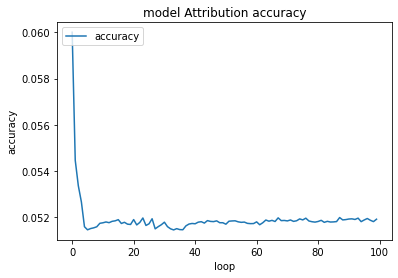

----- train acc -----
binary_acc_train:  [0.9311368465423584, 0.9304263591766357, 0.9428940415382385, 0.950775146484375, 0.9594960808753967, 0.9651162028312683, 0.9653745889663696, 0.9728035926818848, 0.9742893576622009, 0.9770671129226685, 0.9806201457977295, 0.9812015295028687, 0.9837855696678162, 0.9847545623779297, 0.9877906441688538, 0.9886950850486755, 0.9912790060043335, 0.9917959570884705, 0.9927002787590027, 0.993992269039154, 0.9943153262138367, 0.9945735931396484, 0.9951550960540771, 0.9956071972846985, 0.9961240291595459, 0.9971576929092407, 0.9972222447395325, 0.9968992471694946, 0.9969637989997864, 0.998320460319519, 0.9978682994842529, 0.9982559084892273, 0.9983205199241638, 0.9986435174942017, 0.9989664554595947, 0.9986435174942017, 0.999095618724823, 0.9995478391647339, 0.9990310072898865, 0.9994186758995056, 0.9997416138648987, 0.9998062252998352, 0.9996124505996704, 0.9998062252998352, 0.9996124505996704, 0.9999353885650635, 0.9999353885650635, 0.9999353885650635, 0.

In [10]:
class TestTranslate(unittest.TestCase):

    def test_translate(self):

        s1 = 35
        s2 = 35
        s3 = 35
        new_model = newmodel(model)
        # method = 'riemann_left', 'riemann_right', 'riemann_middle', 'riemann_trapezoid', 'gausslegendre'
        n_steps = 6
        ig  = IntegratedGradients1(new_model,
                    layer=new_model.layers[1],
                    n_steps=n_steps,
                    method='riemann_trapezoid',
                    internal_batch_size=32)
        type_weight = 1
        learning_rate_value = 0.0001
        batch_size_num = 32
        epochs_value = 10
        losses = {"classifier_model": "binary_crossentropy"}
        lossWeights = {"classifier_model": type_weight}
        metrics = {"classifier_model": "binary_accuracy"}
        alpha = 0.5
        eta = 0.5
        print('Start: ', get_gpu_memory())
        for i in range(100):
            print('----- loop', i, ': ', get_gpu_memory(), ' -----')
            start = time.time()
        #---產生資料---
            # --- train data---
            print('########## train data ##########')
            start_train = time.time()
            start_delta_l = time.time()
            for b in range(0,num_train,s1):
                e = b + s1
                if e>num_train: e = num_train
                #print('-----', b, '-----', e, '-----')
                #print('xtrain[b:e] shape: ', xtrain[b:e].shape) #(s,1001,32)
                #print('ytrain[b:e] shape: ', ytrain[b:e].shape) #(s,36)

                # delta_l = -alpha * grad_loss
                with tf.GradientTape() as g:
                    x = xtrain[b:e]
                    y = ytrain[b:e]
                    g.watch(x)
                    y_true = y
                    y_pred = new_model(x)
                    loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
                    #print('loss: ', loss)
                gt = g.gradient(loss, x)
                #print('gt: ', gt)
                delta_l = -alpha * gt
                #print('delta_l shape: ', delta_l.shape) #(s,1001,32)
                newtrain[b:e] = xtrain[b:e] + delta_l
            end_delta_l = time.time()
            print('train data delta_l time: ', end_delta_l-start_delta_l)

            start_delta_a = time.time()
            for b in range(0,num_train,s2):
                e = b + s2
                if e>num_train: e = num_train
                #print('-----', b, '-----', e, '-----')
                #print('xtrain[b:e] shape: ', xtrain[b:e].shape) #(s,1001,32)
                #print('ytrain[b:e] shape: ', ytrain[b:e].shape) #(s,36)

                # delta_a = -eta * ( attrx - attrx_ ) * attrx_gradient
                x = np.asarray(xtrain).astype('float32')
                predictions = new_model(xtrain[b:e]).numpy()
                #print('86: ', get_gpu_memory())
                explanation = ig.explain(x[b:e], baselines=None, target=predictions, attribute_to_layer_inputs=False).attributions[0]
                #print('88: ', get_gpu_memory())
                attrx = explanation
                #print('attrx shape: ', attrx.shape) #(s,1001,32)
                attrx_ = xtrain_attr[b:e]
                #print('attrx_ shape: ', attrx_.shape) #(s,1001,32)
                mk = ig._mk()
                #attrx_gradient = attrx_grad(xtrain[b:e], attrx, mk, new_model, n_steps)
                zk_grad_x = attrx / xtrain[b:e]
                zk_grad2_zk = 0
                for j in range(n_steps):
                    zk = xtrain[b:e] * mk[j]
                    with tf.GradientTape() as g:
                        x = xtrain[b:e]
                        g.watch(x)
                        with tf.GradientTape() as gg:
                            gg.watch(x)
                            loss = new_model(x)
                        ggt = gg.gradient(loss, x)
                    gt = g.gradient(ggt, x)
                    ans = gt * (mk[j] * mk[j])
                    zk_grad2_zk += ans
                attrx_gradient = zk_grad_x + (xtrain[b:e]/n_steps) + zk_grad2_zk
                #print('attrx_gradient shape: ', attrx_gradient.shape) #(s,1001,32)
                delta_a = -eta * ( attrx - attrx_ ) * attrx_gradient
                #print('delta_a shape: ', delta_a.shape) #(s,1001,32)
                newtrain[b:e] = newtrain[b:e] + delta_a
            end_delta_a = time.time()
            print('train data delta_a time: ', end_delta_a-start_delta_a)
            #saveTestTrainData('D:/00/train.npy', newx0)
            #print(newx)
            end_train = time.time()
            print('train data time: ', end_train-start_train)
            '''
            new_model.compile(optimizer=Adam(learning_rate=learning_rate_value), loss=losses, loss_weights=lossWeights, metrics=metrics)
            x = np.asarray(newtrain).astype('float32')
            y = np.asarray(ytrain[0:num_train]).astype('float32')
            new_model.evaluate(x, y)
            '''

            # --- validation data ---
            print('########## validation data ##########')
            start_validation = time.time()
            start_delta_l = time.time()
            for b in range(0,num_validation,s1):
                e = b + s1
                if e>num_validation: e = num_validation
                #print('-----', b, '-----', e, '-----')
                #print('xvalidation[b:e] shape: ', xvalidation[b:e].shape) #(s,1001,32)
                #print('yvalidation[b:e] shape: ', yvalidation[b:e].shape) #(s,36)

                # delta_l = -alpha * grad_loss
                with tf.GradientTape() as g:
                    x = xvalidation[b:e]
                    y = yvalidation[b:e]
                    g.watch(x)
                    y_true = y
                    y_pred = new_model(x)
                    loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
                    #print('loss: ', loss)
                #print('149: ', get_gpu_memory())
                gt = g.gradient(loss, x)
                #print('151: ', get_gpu_memory())
                #print('gt: ', gt)
                delta_l = -alpha * gt
                #print('delta_l shape: ', delta_l.shape) #(s,1001,32)
                newvalidation[b:e] = xvalidation[b:e] + delta_l
            end_delta_l = time.time()
            print('validation data delta_l time: ', end_delta_l-start_delta_l)

            start_delta_a = time.time()
            for b in range(0,num_validation,s2):
                e = b + s2
                if e>num_validation: e = num_validation
                #print('-----', b, '-----', e, '-----')
                #print('xvalidation[b:e] shape: ', xvalidation[b:e].shape) #(s,1001,32)
                #print('yvalidation[b:e] shape: ', yvalidation[b:e].shape) #(s,36)

                # delta_a = -eta * ( attrx - attrx_ ) * attrx_gradient
                x = np.asarray(xvalidation).astype('float32')
                predictions = new_model(xvalidation[b:e]).numpy()
                #print('166: ', get_gpu_memory())
                explanation = ig.explain(x[b:e], baselines=None, target=predictions, attribute_to_layer_inputs=False).attributions[0]
                #print('168: ', get_gpu_memory())
                attrx = explanation
                #print('attrx shape: ', attrx.shape) #(s,1001,32)
                attrx_ = xvalidation_attr[b:e]
                #print('attrx_ shape: ', attrx_.shape) #(s,1001,32)
                mk = ig._mk()
                #attrx_gradient = attrx_grad(xvalidation[b:e], attrx, mk, new_model, n_steps)
                zk_grad_x = attrx / xvalidation[b:e]
                zk_grad2_zk = 0
                for j in range(n_steps):
                    zk = xvalidation[b:e] * mk[j]
                    with tf.GradientTape() as g:
                        x = xvalidation[b:e]
                        g.watch(x)
                        with tf.GradientTape() as gg:
                            gg.watch(x)
                            loss = new_model(x)
                        ggt = gg.gradient(loss, x)
                    gt = g.gradient(ggt, x)
                    ans = gt * (mk[j] * mk[j])
                    zk_grad2_zk += ans
                attrx_gradient = zk_grad_x + (xvalidation[b:e]/n_steps) + zk_grad2_zk
                #print('attrx_gradient shape: ', attrx_gradient.shape) #(s,1001,32)
                delta_a = -eta * ( attrx - attrx_ ) * attrx_gradient
                #print('delta_a shape: ', delta_a.shape) #(s,1001,32)
                newvalidation[b:e] = newvalidation[b:e] + delta_a
            end_delta_a = time.time()
            print('validation data delta_a time: ', end_delta_a-start_delta_a)
            #saveTestvalidationData('D:/00/validation.npy', newx0)
            #print(newx)
            end_validation = time.time()
            print('validation data time: ', end_validation-start_validation)
            '''
            new_model.compile(optimizer=Adam(learning_rate=learning_rate_value), loss=losses, loss_weights=lossWeights, metrics=metrics)
            x = np.asarray(newvalidation).astype('float32')
            y = np.asarray(yvalidation[0:num_validation]).astype('float32')
            new_model.evaluate(x, y)
            '''

        #----- training new model -----
            print('########## training new model ##########')
            xtrain0 = xtrain[0:num_train]
            ytrain0 = ytrain[0:num_train]
            x_train = np.concatenate((xtrain0, newtrain), axis=0)
            x_train = np.asarray(x_train).astype('float32')
            y_train = np.concatenate((ytrain0, ytrain0), axis=0)
            xvalidation0 = xvalidation[0:num_validation]
            yvalidation0 = yvalidation[0:num_validation]
            x_validation = np.concatenate((xvalidation0, newvalidation), axis=0)
            x_validation = np.asarray(x_validation).astype('float32')
            y_validation = np.concatenate((yvalidation0, yvalidation0), axis=0)
            #print('x_train shape: ', x_train.shape) #(num_train*2,1001,32)
            #print('y_train shape: ', y_train.shape) #(num_train*2,36)
            #print('x_validation shape: ', x_validation.shape) #(num_validation*2,1001,32)
            #print('y_validation shape: ', y_validation.shape) #(num_validation*2,36)
            new_model.compile(optimizer=Adam(learning_rate=learning_rate_value), loss=losses, loss_weights=lossWeights, metrics=metrics)

            history = new_model.fit(
                          x = x_train,
                          y = y_train,
                          epochs = epochs_value, #100 200 500 3000
                          verbose = 2, #set visibility
                          #callbacks = [model_checkpoint_callback],
                          validation_data = (x_validation, y_validation), #-> has issue 
                          batch_size = batch_size_num
                          )

        #----- binary acc & mse -----
            print('########## binary acc & mse ##########')

            binary_acc_train .append(history.history['binary_accuracy'][epochs_value-1])
            binary_acc_validation .append(history.history['val_binary_accuracy'][epochs_value-1])
            print('binary_accuracy train: ', history.history['binary_accuracy'][epochs_value-1])
            print('binary_accuracy validation: ', history.history['val_binary_accuracy'][epochs_value-1])

            # ---- attribution train -----
            print('---- attribution train -----')
            start_att = time.time()
            for b in range(0,num_train*2,s3):
                e = b + s3
                if e>num_train*2: e = num_train*2
                #print('-----', b, '-----', e, '-----')
                #print('x_train[b:e] shape: ', x_train[b:e].shape)
                #print('y_train[b:e] shape: ', y_train[b:e].shape)

                predictions = y_train[b:e]
                #print('254: ', get_gpu_memory())
                explanation = ig.explain(x_train[b:e], baselines=None, target=predictions, attribute_to_layer_inputs=False)
                #print('256: ', get_gpu_memory())
                attr_train[b:e] = explanation.attributions[0]

            attr_train_pred = tf.abs(attr_train)
            attr_train_pred = tf.reduce_sum(attr_train_pred, axis=2).numpy()/32
            #print('attr_train_pred shape: ', attr_train_pred.shape) #(num_train*2,1001)
            attr_train_true = xtrain_attr[0:num_train]
            attr_train_true = tf.reduce_sum(attr_train_true, axis=2).numpy()/32
            attr_train_true = tf.concat([attr_train_true, attr_train_true], 0)
            #print('attr_train_true shape: ', attr_train_true.shape) #(num_train*2,1001)
            #average = tf.reduce_sum(attrx_pred, axis=1).numpy()/1001
            #print('average: ', average)
            mse = tf.keras.losses.MeanSquaredError()
            attr_mse = mse(attr_train_true, attr_train_pred).numpy()
            attr_mse_train.append(attr_mse)
            print('attr_mse train: ', attr_mse)
            end_att = time.time()
            print('train attribution time: ', end_att-start_att)
            # ---- attributoin validation -----
            print('---- attribution validation -----')
            start_att = time.time()
            for b in range(0,num_validation*2,s3):
                e = b + s3
                if e>num_validation*2: e = num_validation*2
                #print('-----', b, '-----', e, '-----')
                #print('x_validation[b:e] shape: ', x_validation[b:e].shape)
                #print('y_validation[b:e] shape: ', y_validation[b:e].shape)

                predictions = y_validation[b:e]
                #print('285: ', get_gpu_memory())
                explanation = ig.explain(x_validation[b:e], baselines=None, target=predictions, attribute_to_layer_inputs=False)
                #print('287: ', get_gpu_memory())
                attr_validation[b:e] = explanation.attributions[0]
            attr_validation_pred = tf.abs(attr_validation)
            attr_validation_pred = tf.reduce_sum(attr_validation_pred, axis=2).numpy()/32
            #print('attr_validation_pred shape: ', attr_validation_pred.shape) #(num_validation*2,1001)
            attr_validation_true = xvalidation_attr[0:num_validation]
            attr_validation_true = tf.reduce_sum(attr_validation_true, axis=2).numpy()/32
            attr_validation_true = tf.concat([attr_validation_true, attr_validation_true], 0)
            #print('attr_validation_true shape: ', attr_validation_true.shape) #(num_validation*2,1001)
            mse = tf.keras.losses.MeanSquaredError()
            attr_mse = mse(attr_validation_true, attr_validation_pred).numpy()
            attr_mse_validation.append(attr_mse)
            print('attr_mse validation: ', attr_mse)
            end_att = time.time()
            print('validation attribution time: ', end_att-start_att)
            end = time.time()
            print('time: ', end-start)
        plotAttributionAcc(attr_mse_train)
        print('----- train acc -----')
        print('binary_acc_train: ', binary_acc_train)
        print('attr_mse_train: ', attr_mse_train)
        print('----- validation acc -----')
        print('binary_acc_validation: ', binary_acc_validation)
        print('attr_mse_validation: ', attr_mse_validation)
            #print("Model training completed...")
            #save history
            #print("Saving history...")
            #saveDictionary(history.history, Trained_model_Path + "/" + "model_history")
            #print("History saving completed...")

            #save model
            #print("Saving model...")
            #model.save(Trained_model_Path + "/" + "test_model1.h5")
            #print("Model saving completed...")

x=TestTranslate()
x.test_translate()

In [11]:
import tensorflow as tf
import numpy as np 
# Data`
x1 = loadTestTrainData('C:/Users/YOLOHsu/Desktop/10366046/Max-len-1000/x_train[0]_0.npy')
x2 = loadTestTrainData('D:/00/train.npy')
x1 = np.asarray(x1)
x2 = np.asarray(x2).astype('float32')
print('x1 shape: ', x1.shape)
print('x2 shape: ', x2.shape)
y0 = list(loadTestTrainData('C:/Users/YOLOHsu/Desktop/10366046/Max-len-1000/y_train[0]_0.npy'))
y0 = np.asarray(y0)
print('y0 shape: ', y0.shape)
# model
new_model = newmodel(model)
type_weight = 1
learning_rate_value = 0.0001
batch_size_num = 32
epochs_value = 10
losses = {"classifier_model": "binary_crossentropy"}
lossWeights = {"classifier_model": type_weight}
metrics = {"classifier_model": "binary_accuracy"}
# evaluate
model.compile(optimizer=Adam(learning_rate=learning_rate_value), loss=losses, loss_weights=lossWeights, metrics=metrics)
new_model.compile(optimizer=Adam(learning_rate=learning_rate_value), loss=losses, loss_weights=lossWeights, metrics=metrics)
result1 = model.evaluate(x1, y0)
result2 = new_model.evaluate(x2, y0)
print('result1: ', result1)
print('result2: ', result2)

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/YOLOHsu/Desktop/10366046/Max-len-1000/x_train[0]_0.npy'

In [ ]:
print(get_gpu_memory())